In [60]:
import os
import sys

import random
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
import speclite.filters
import matplotlib.patches as mpatches
import scipy
from phrosty import plotting
from scipy.stats import chi2
from corner import corner

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import roman_util, util
from mejiro.lenses import lens_util
from mejiro.plots import plot_util

In [ ]:
masses = np.linspace(1e8, 1e10, 100)
sides = 2

In [ ]:
save_dir = os.path.join(config.machine.data_dir, 'output', 'lowest_detectable_subhalo_mass_dev')
results = util.unpickle_all(save_dir, 'results_', '.pkl')
detectable_halos = util.unpickle_all(save_dir, 'detectable_halos_', '.pkl')

file_list = glob(save_dir + f"/results_*.pkl")
sorted_list = sorted(file_list)
uids = [os.path.basename(f).split('_')[1][:-4] for f in sorted_list]
# pprint(uids)

pval_threshold = 0.001  # three sigma

In [63]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
# debugging = True  # TODO TEMP

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

detectable_lenses = lens_util.get_detectable_lenses(pipeline_dir, with_subhalos=False, verbose=True)

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]


In [64]:
# randomly select some results to plot
idxs = np.random.randint(0, len(results), 7)

# sort results by redshift
results_to_plot = []

for idx in idxs:
    result = results[idx]
    uid = uids[idx]
    lens = [l for l in detectable_lenses if l.uid == uid][0]
    z = lens.z_lens

    results_to_plot.append((result, z))

results_to_plot = sorted(results_to_plot, key=lambda x: x[1])

100%|██████████| 20/20 [00:00<00:00, 282.09it/s]


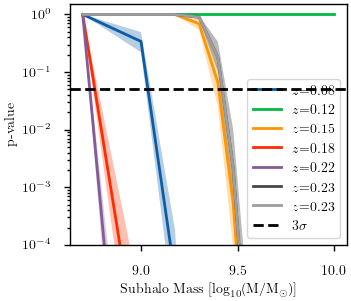

In [65]:
fontsize = 10
matplotlib.rcParams["font.size"] = fontsize

# masses = masses[::10]

f, ax = plt.subplots(1, 1, figsize=(3.5, 3), constrained_layout=True)  # 

for result, z in results_to_plot:
    mass_pvals, uplims, lolims = [], [], []
    for mass in tqdm(masses):

        position_pvals, maxes, mins = [], [], []
        for position_key in list(results[0].keys()):
            pvals = result[position_key][str(int(mass))]
            position_pvals.append(np.median(pvals))

        maxes.append(np.max(position_pvals))
        mins.append(np.min(position_pvals))
        mass_pvals.append(np.median(position_pvals))
        uplims.append(np.max(position_pvals))
        lolims.append(np.min(position_pvals))

    ax.plot(np.log10(masses), mass_pvals, label=rf'$z$={z:.2f}')
    ax.fill_between(np.log10(masses), uplims, lolims, alpha=0.3)

ax.axhline(pval_threshold, color='black', linestyle='--', label=f'3$\sigma$', zorder=1e3)

ax.set_xlabel(r'Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
ax.set_ylabel('p-value')
# plt.xscale('log')
plt.yscale('log')
# ax.set_xlim(8.9, 10.9)
ax.set_ylim(10e-5, 1.5e0)
ax.legend()  # loc='upper right'

for item in ([ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels() + 
              ax.get_legend().get_texts()):
     item.set_fontsize(fontsize)

plt.savefig(os.path.join(figure_dir, 'pvals.png'))
plt.show()

In [66]:
positions = []
for i in range(1, 19):
    sca = str(i).zfill(2)
    coords = roman_util.divide_up_sca(sides)
    for coord in coords:
        positions.append((sca, coord))

In [67]:
# all systems must have a detectable subhalo at least somewhere in the mass range at all positions across the focal plane
results_to_delete = set()
for k, result in enumerate(results):
    for sca, sca_position in positions:
        position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
        position_results = result[position_key]

        largest_mass_pvals = position_results[str(int(masses[-1]))]
        if np.min(largest_mass_pvals) > pval_threshold:
            print(f'Result {k + 1} at position {position_key} has no detectable subhalo at largest mass {masses[-1]:.2e}')
            results_to_delete.add(k)

print(f'{len(results_to_delete)} result(s) to delete')

results = [result for i, result in enumerate(results) if i not in results_to_delete]
print(f'Keeping {len(results)} result(s)')

Result 10 at position 1_1022_1022 has no detectable subhalo at largest mass 1.00e+10
Result 10 at position 1_1022_3066 has no detectable subhalo at largest mass 1.00e+10
Result 10 at position 1_3066_1022 has no detectable subhalo at largest mass 1.00e+10
Result 10 at position 1_3066_3066 has no detectable subhalo at largest mass 1.00e+10
Result 10 at position 2_1022_1022 has no detectable subhalo at largest mass 1.00e+10
Result 10 at position 2_1022_3066 has no detectable subhalo at largest mass 1.00e+10
Result 10 at position 2_3066_1022 has no detectable subhalo at largest mass 1.00e+10
Result 10 at position 2_3066_3066 has no detectable subhalo at largest mass 1.00e+10
Result 10 at position 3_1022_1022 has no detectable subhalo at largest mass 1.00e+10
Result 10 at position 3_1022_3066 has no detectable subhalo at largest mass 1.00e+10
Result 10 at position 3_3066_1022 has no detectable subhalo at largest mass 1.00e+10
Result 10 at position 3_3066_3066 has no detectable subhalo at la

 97%|█████████▋| 70/72 [00:00<00:00, 696.95it/s]

100%|██████████| 72/72 [00:00<00:00, 693.76it/s]


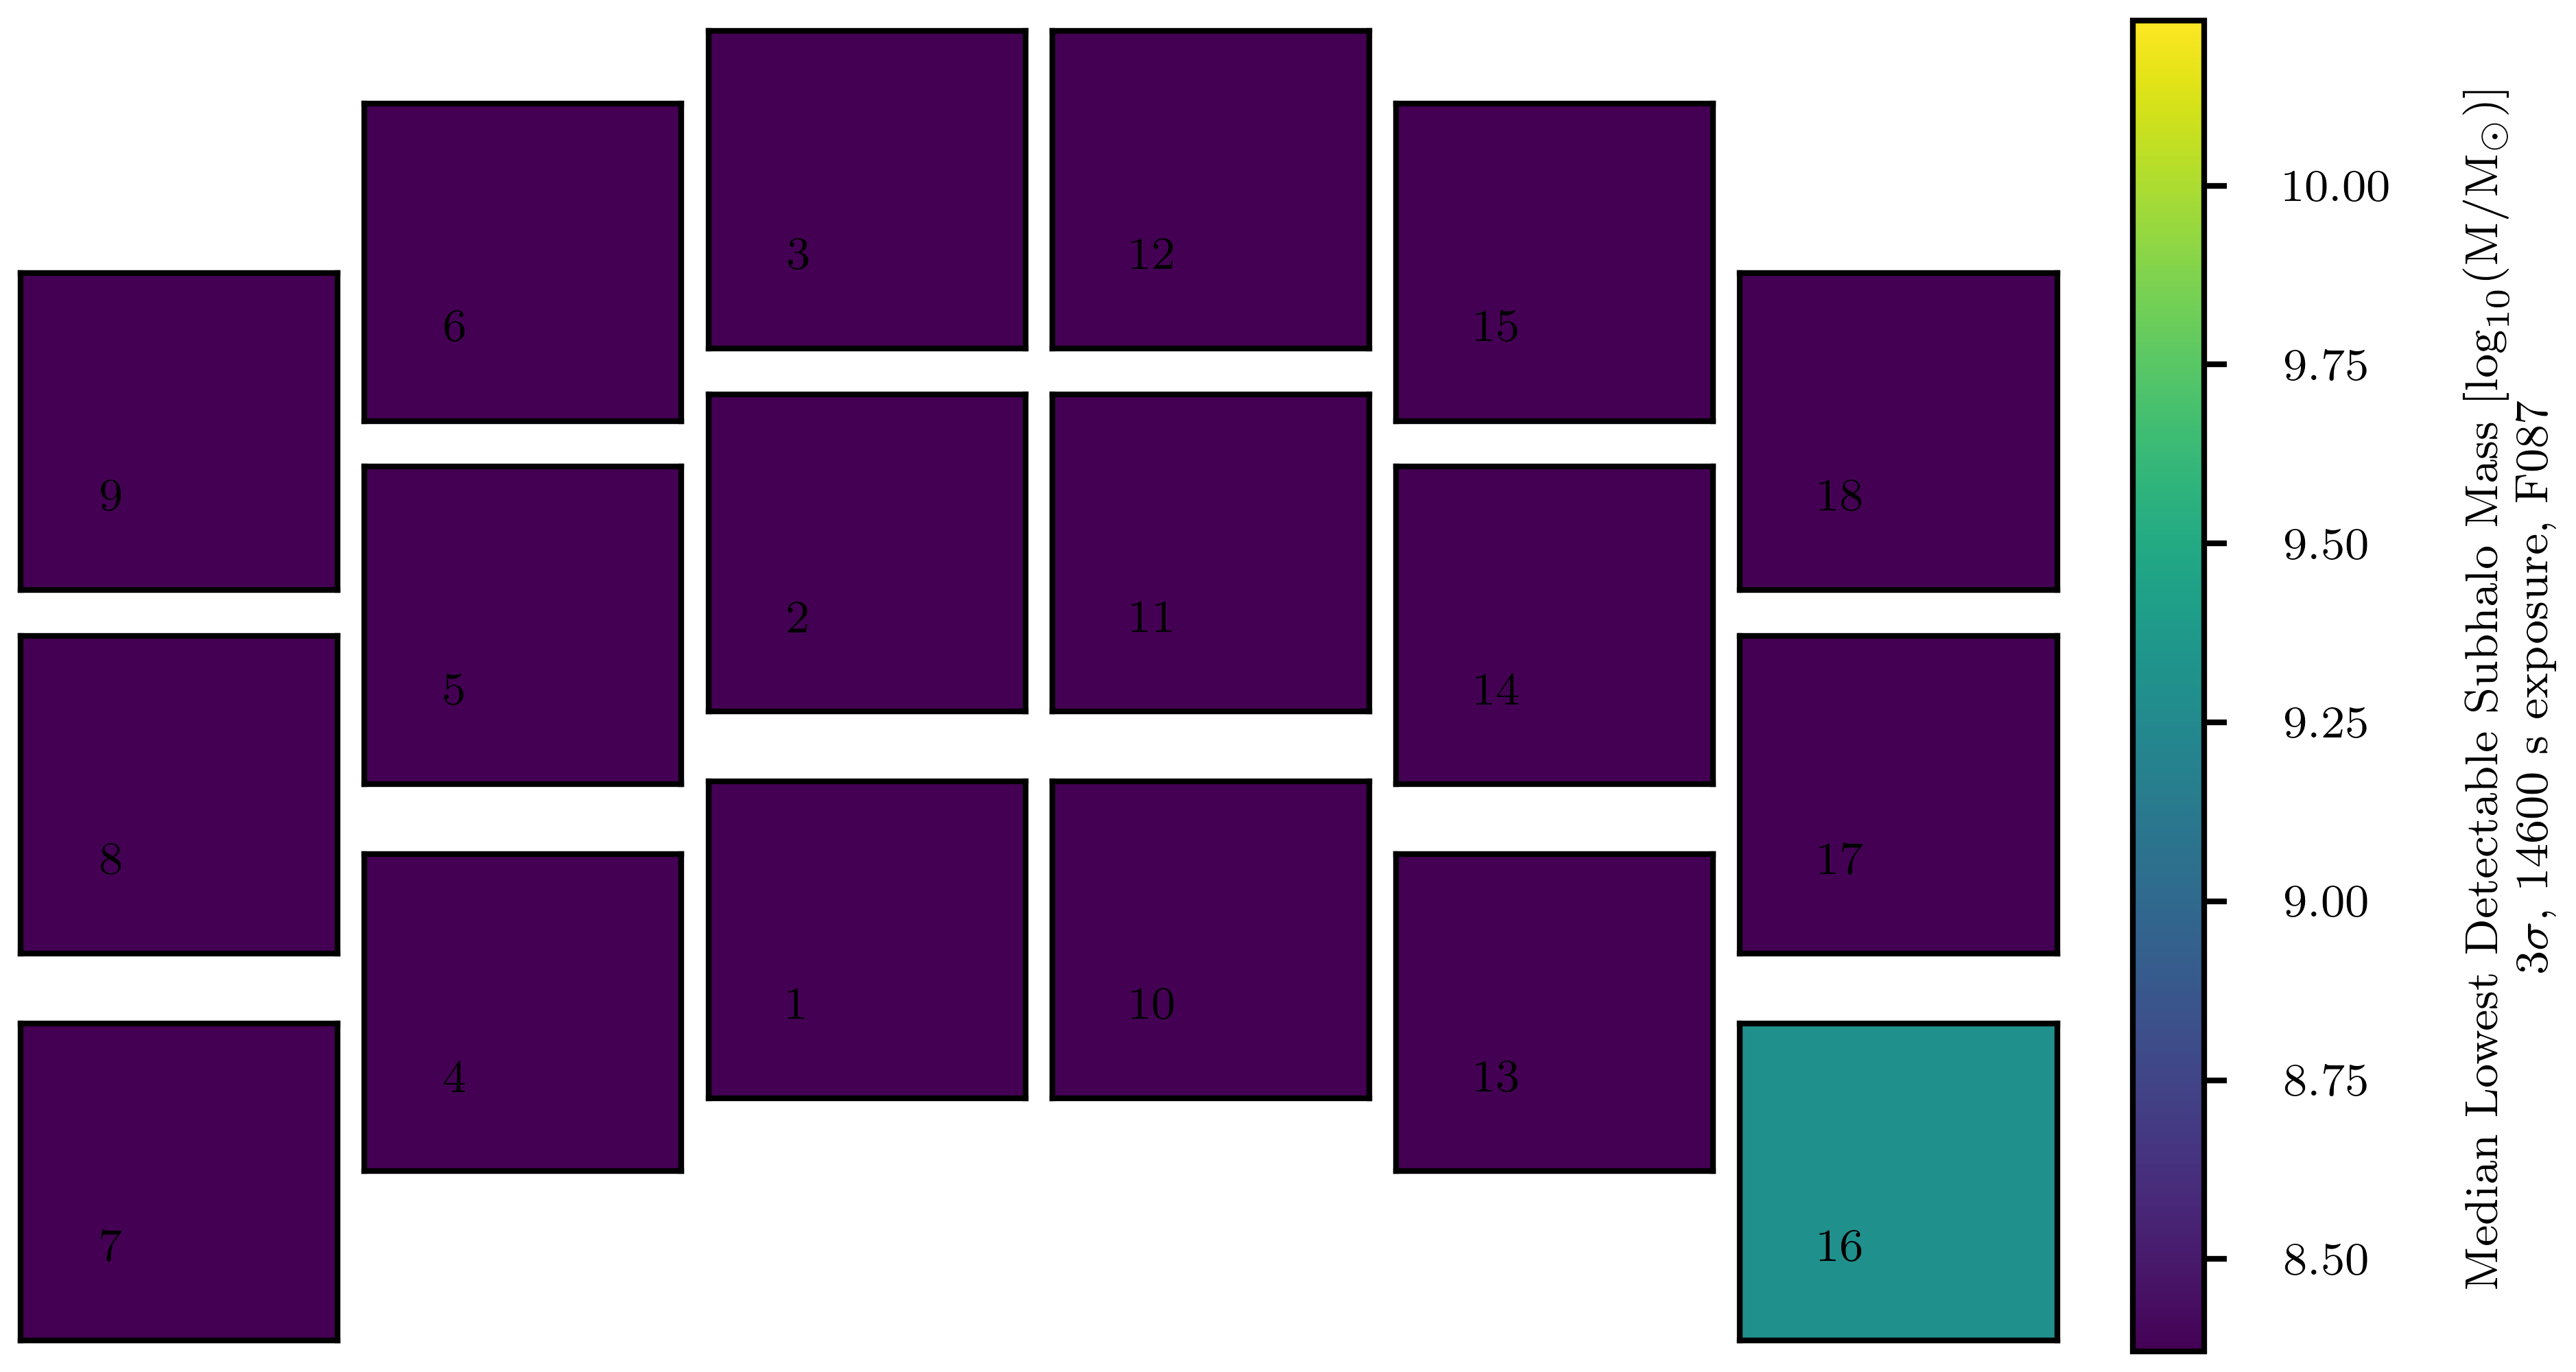

In [68]:
array_list = []

# initialize first array (for SCA 1)
array = np.empty((sides, sides))
means = []

# loop through positions
for sca, sca_position in tqdm(positions):
    position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'

    lowest_det_masses_at_position = []
    for result in results:
        position_results = result[position_key]

        for mass in masses:
            pvals = position_results[str(int(mass))]
            mass = float(mass)
            if np.min(pvals) < pval_threshold:
                # print(f'hit threshold at {mass:.2e}')
                lowest_det_masses_at_position.append(mass)
                break
    
    assert len(lowest_det_masses_at_position) == len(results), f'Not all results have a detectable mass at position {position_key}'

    mean_lowest_det_mass_at_position = np.median(lowest_det_masses_at_position)
    means.append(mean_lowest_det_mass_at_position)

    # if the last position on the SCA has been reached (top-right corner), populate the array with the masses
    if sca_position == roman_util.divide_up_sca(sides)[-1]:  
        assert len(means) == sides * sides, f'Not all positions have been filled for SCA {sca}'

        for i in range(sides):
            for j in range(sides):
                array[i, j] = np.log10(means[j * sides + i])

        array_list.append(array)

        # plt.imshow(array)
        # plt.colorbar()
        # plt.show()

        # reset the array and median list for the next SCA
        array = np.empty((sides, sides))
        means = []

plotting.roman_sca_plot(np.asarray(array_list), 
                        np.arange(1, 19), 
                        residual_plot=False, 
                        show_sca_id=True, 
                        cmap='viridis', 
                        savefig=True, 
                        savepath=os.path.join(figure_dir, f'lowest_detectable_subhalo_mass.png'), 
                        clabel=r'Median Lowest Detectable Subhalo Mass [$\log_{10}$(M/M$_\odot$)]' + '\n3$\sigma$, 14600 s exposure, F087',
                        sca_id_pos=(0,0),
                        fontsize=8)

# f, ax = plt.subplots(3, 6, figsize=(12, 6), constrained_layout=True)
# for i, array in enumerate(array_list):
#     im = ax[i // 6, i % 6].imshow(array, cmap='viridis', vmin=np.log10(masses[0]), vmax=np.log10(masses[-1]))
#     ax[i // 6, i % 6].set_title(f'SCA {i + 1}')
#     ax[i // 6, i % 6].axis('off')
# cbar = f.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
# cbar.set_label(r'Mean Lowest Detectable Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
# plt.show()

In [69]:
# array_list = [i * np.ones((4, 4)) for i in range(1, 19)]

# assert not util.all_arrays_equal(array_list), 'All SCAs have the same detectable mass array'

100%|██████████| 72/72 [00:00<00:00, 20473.89it/s]


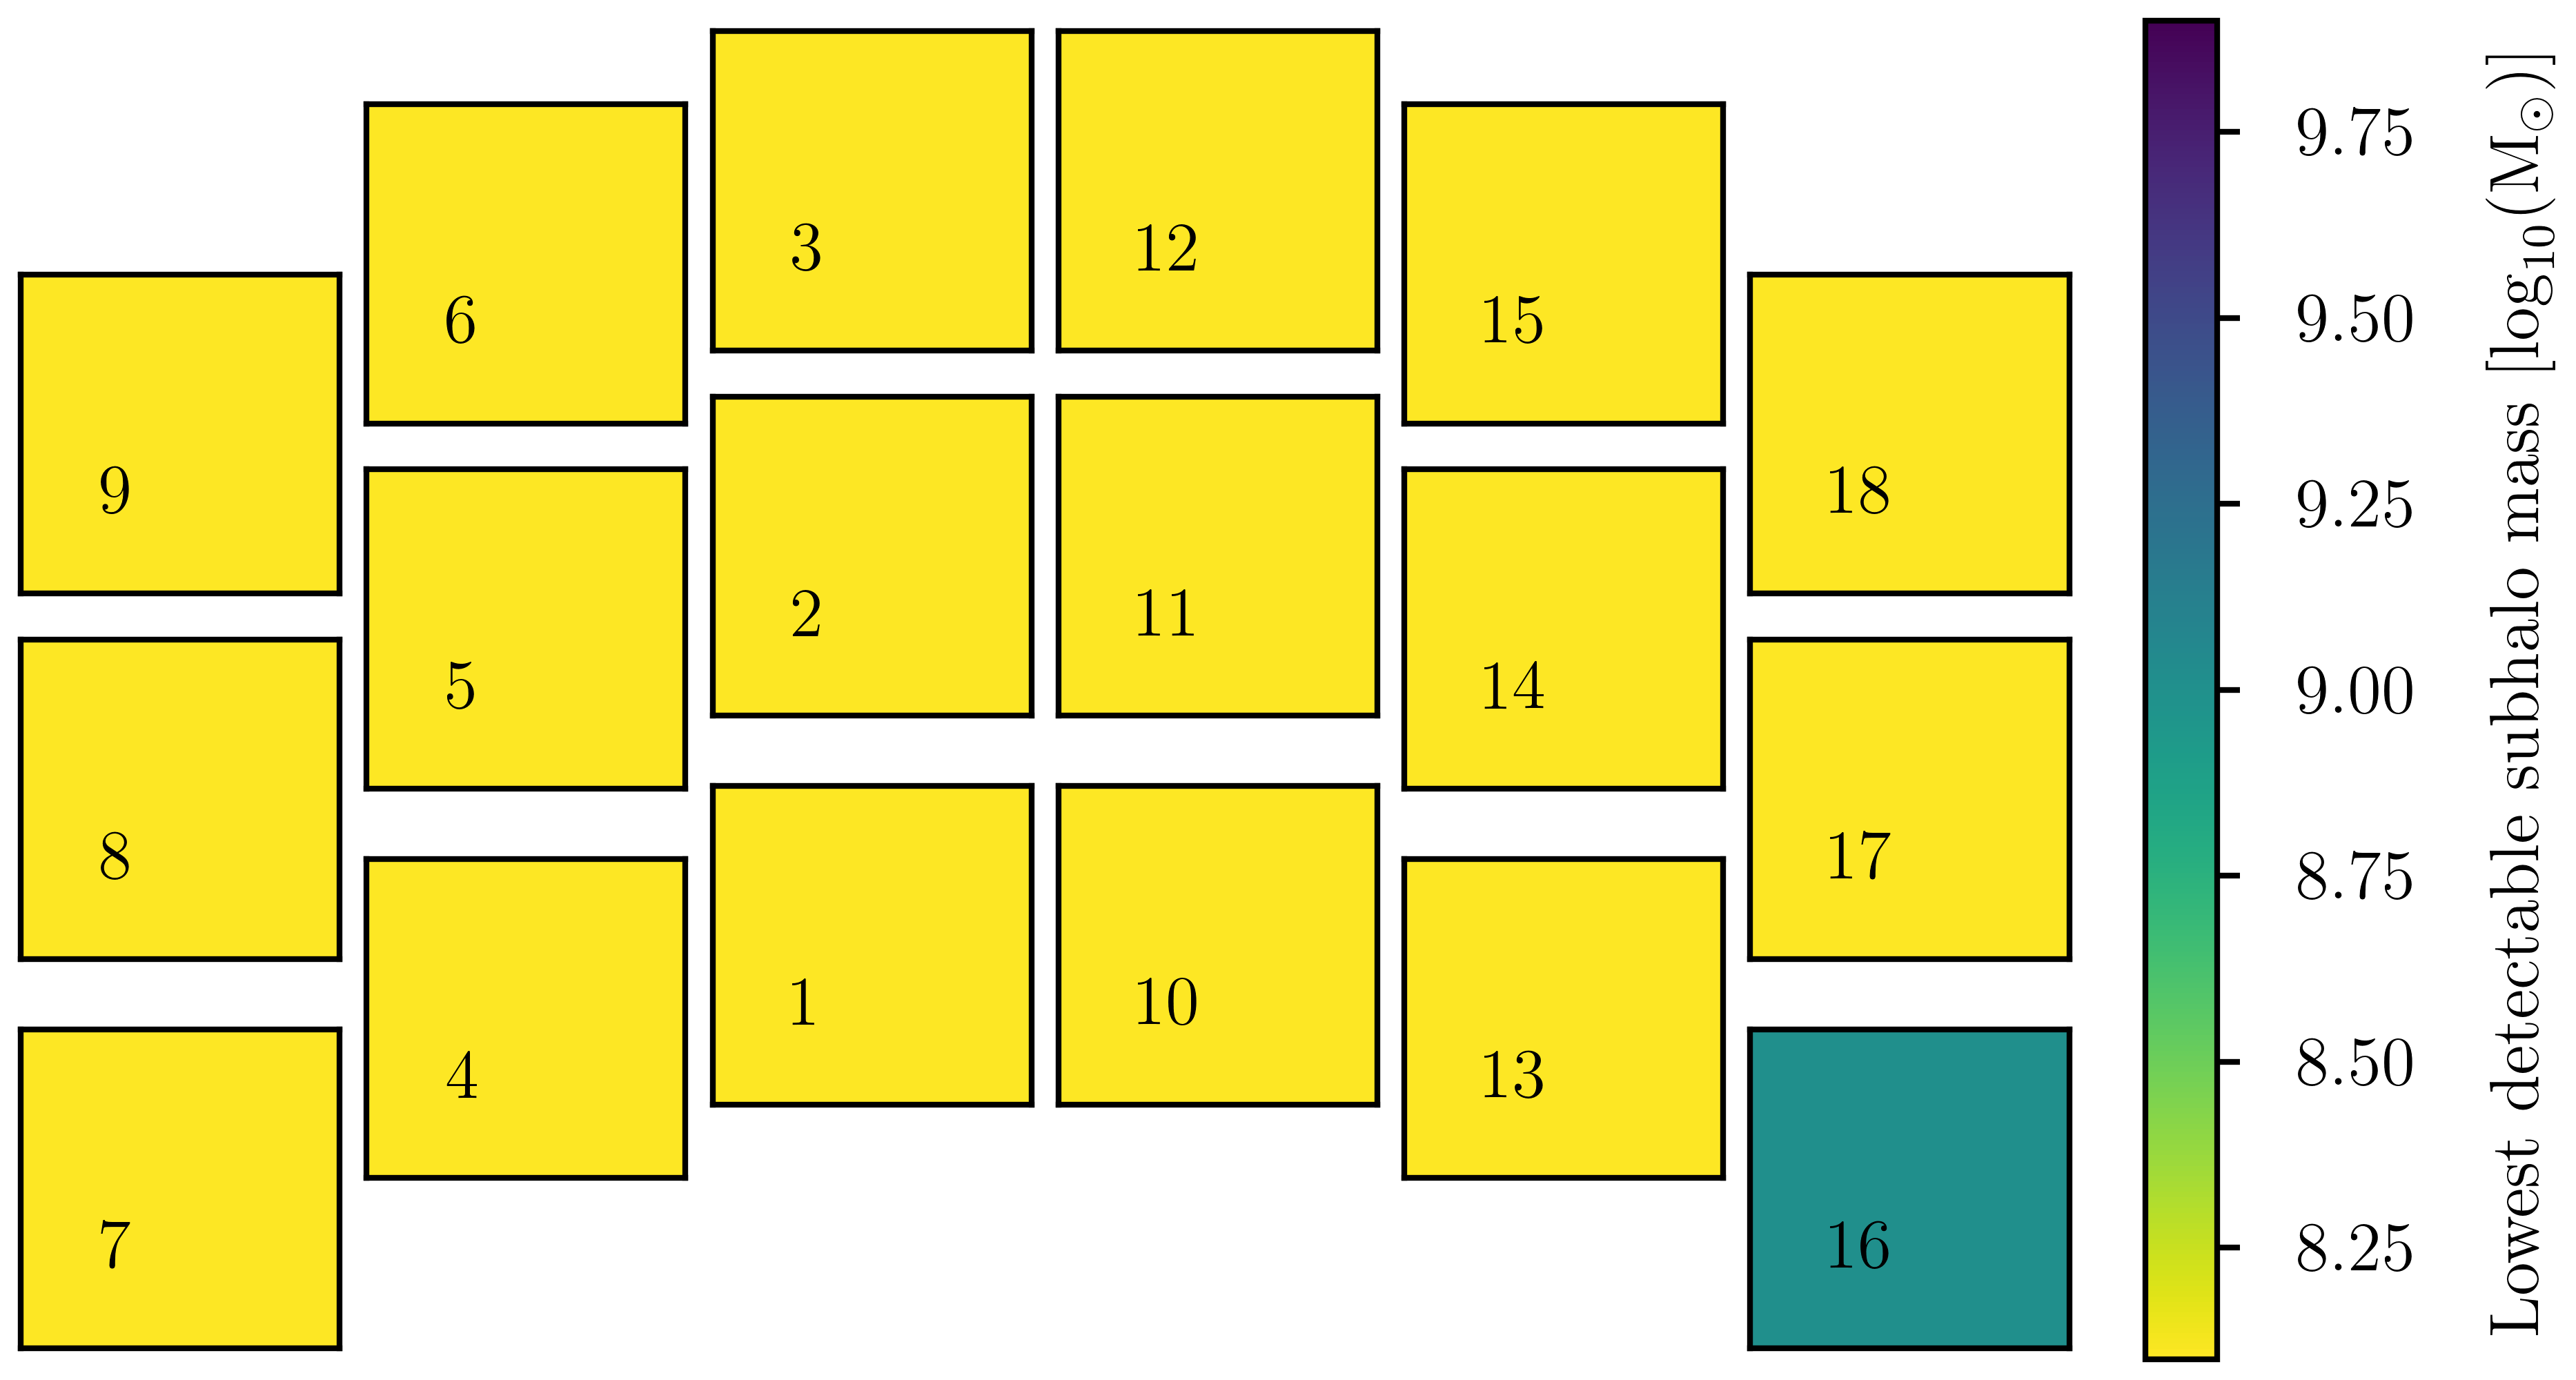

100%|██████████| 72/72 [00:00<00:00, 26049.33it/s]


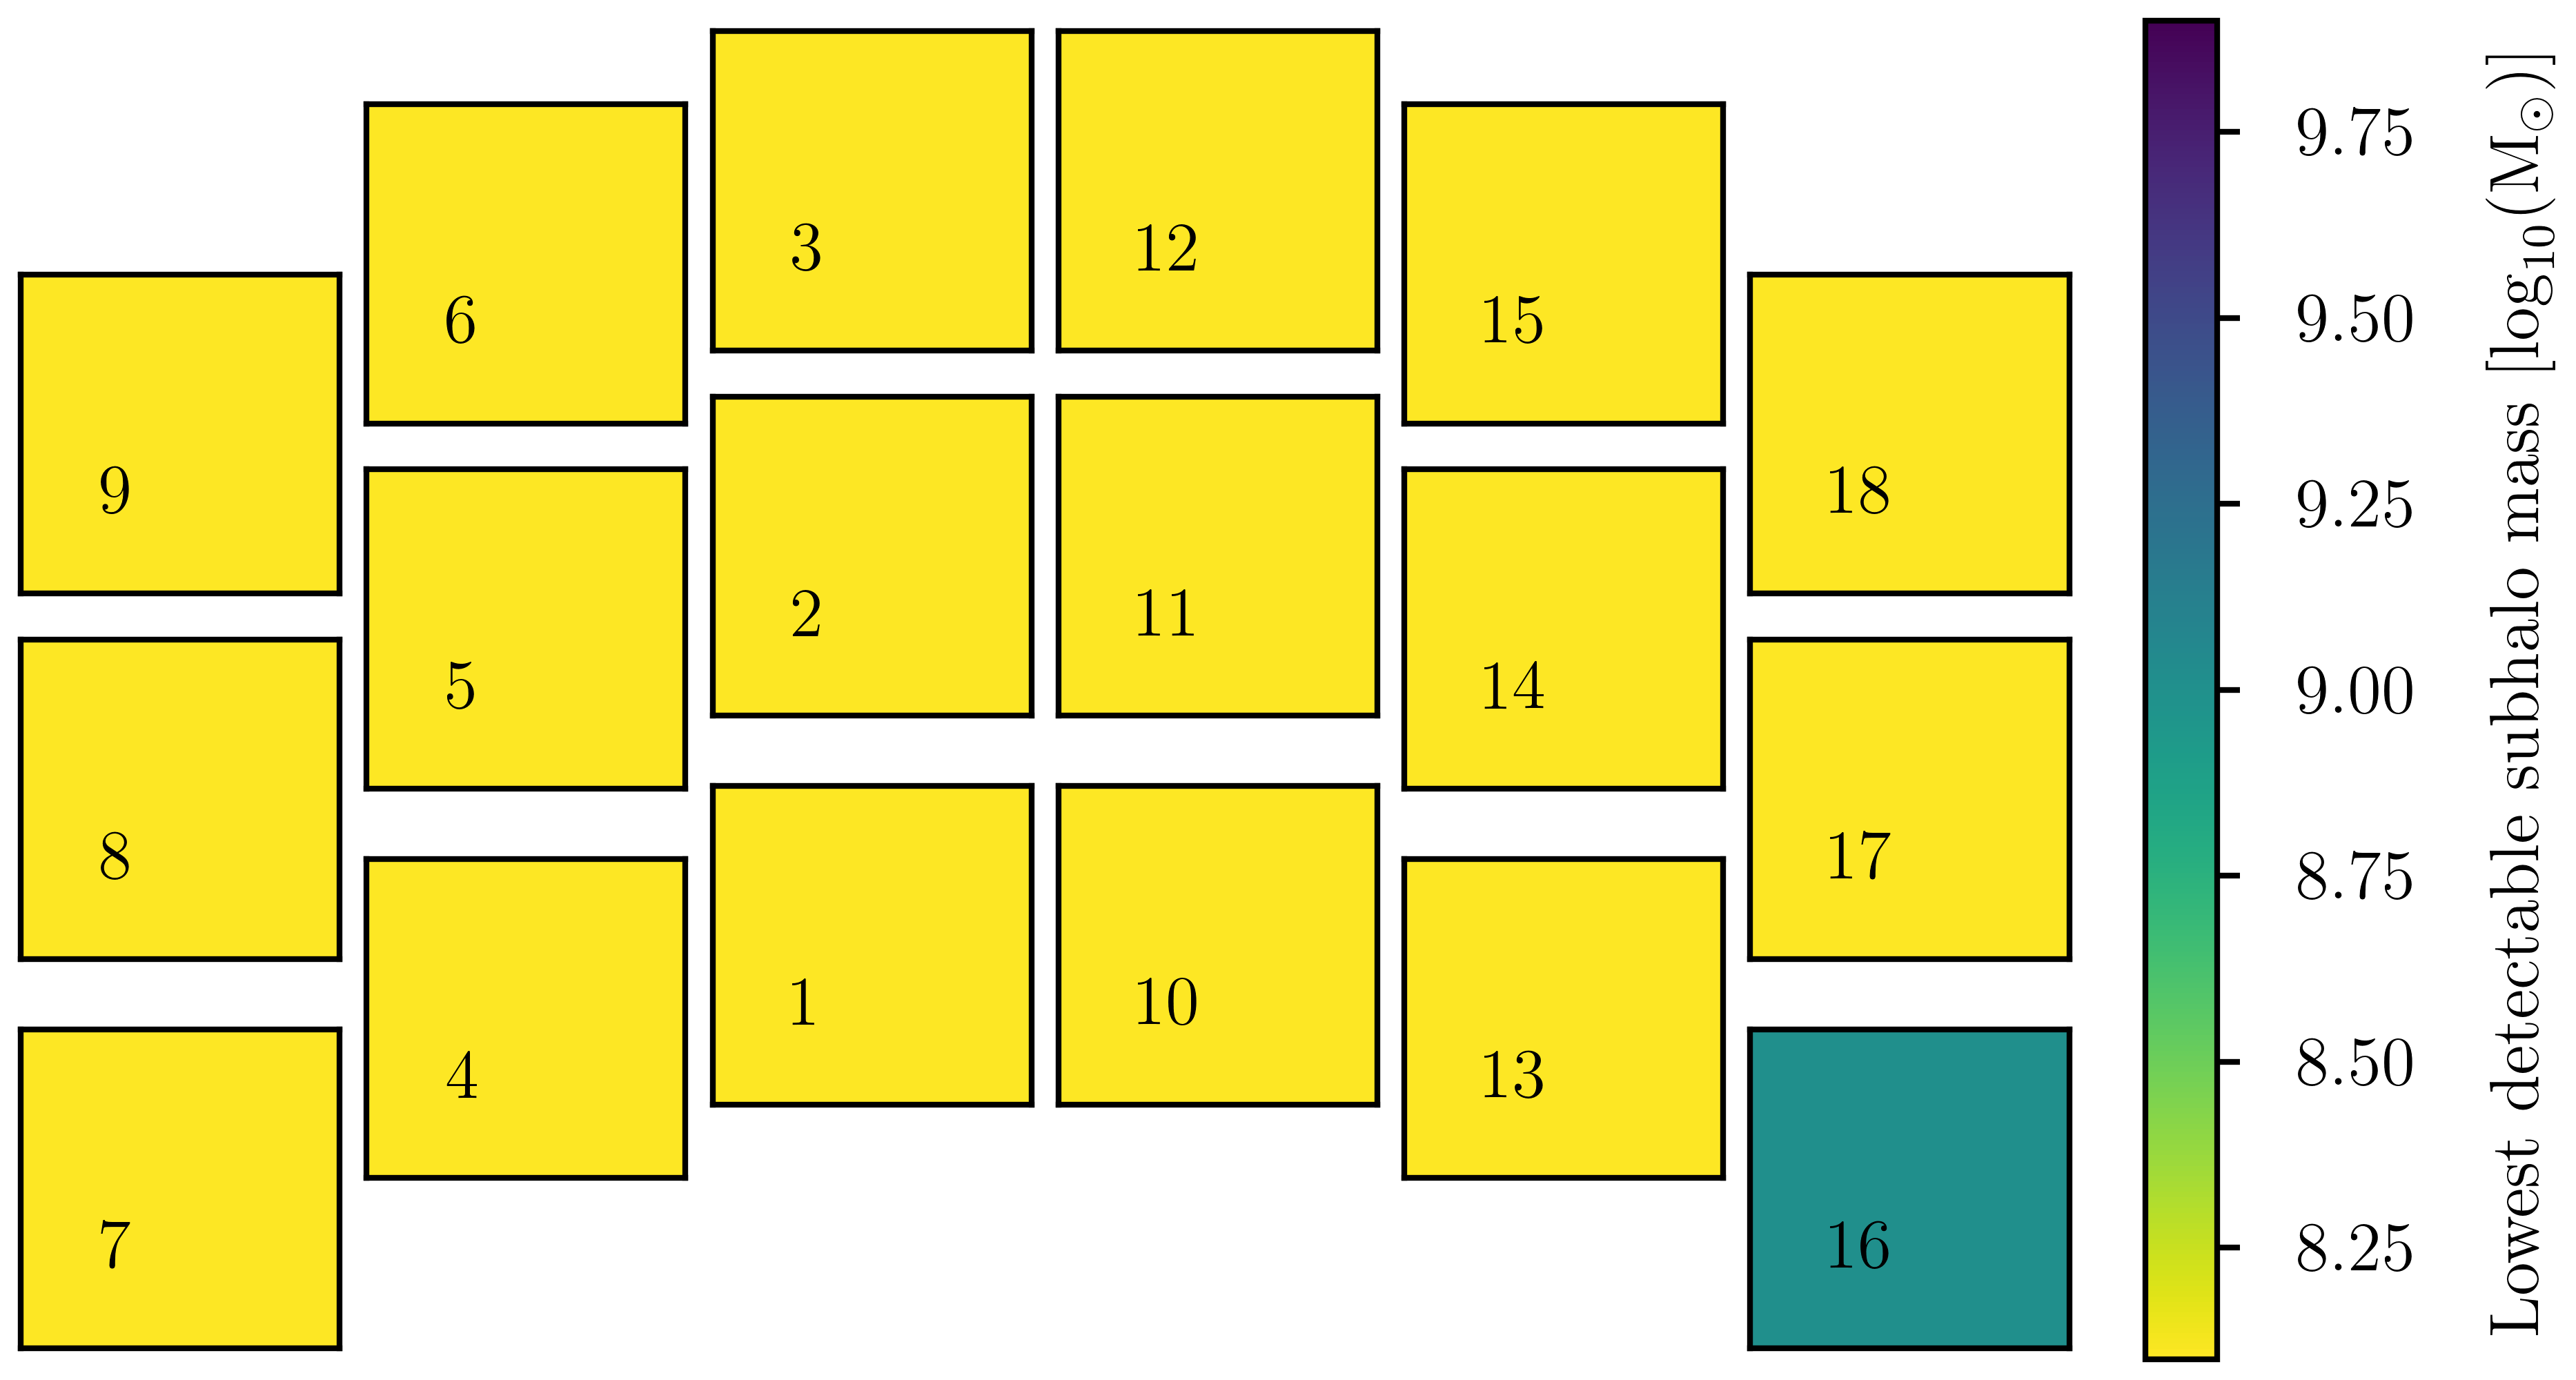

100%|██████████| 72/72 [00:00<00:00, 25443.58it/s]


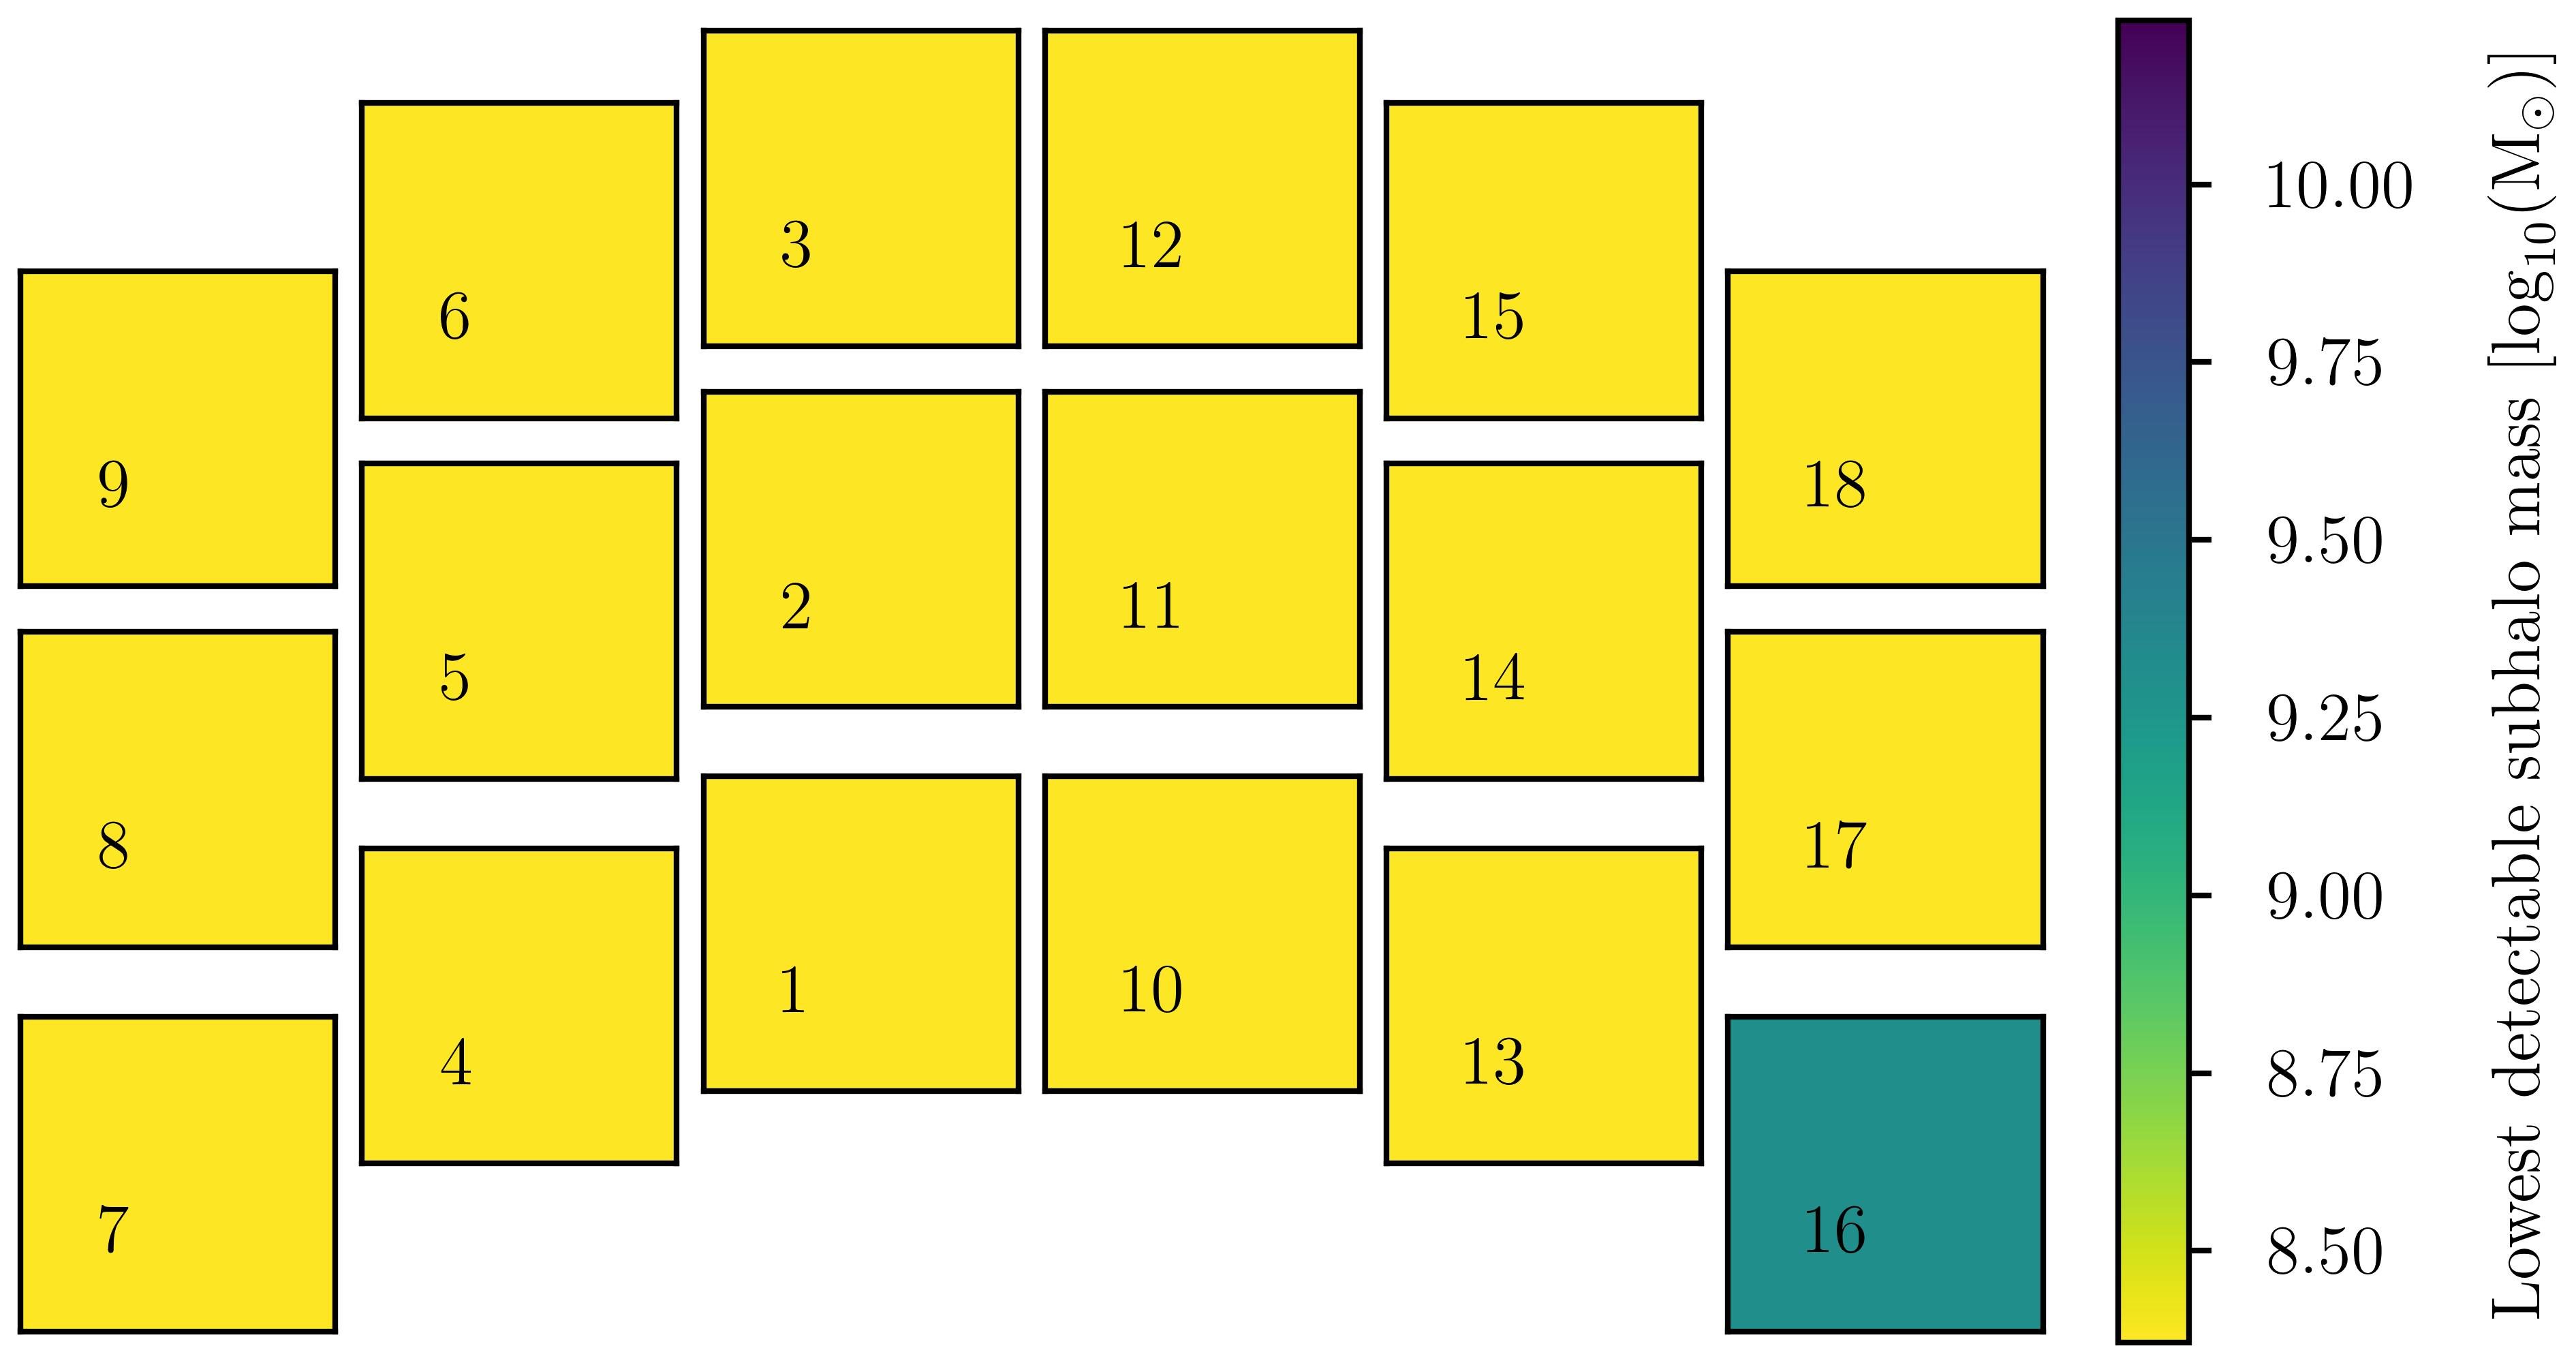

100%|██████████| 72/72 [00:00<00:00, 6651.61it/s]


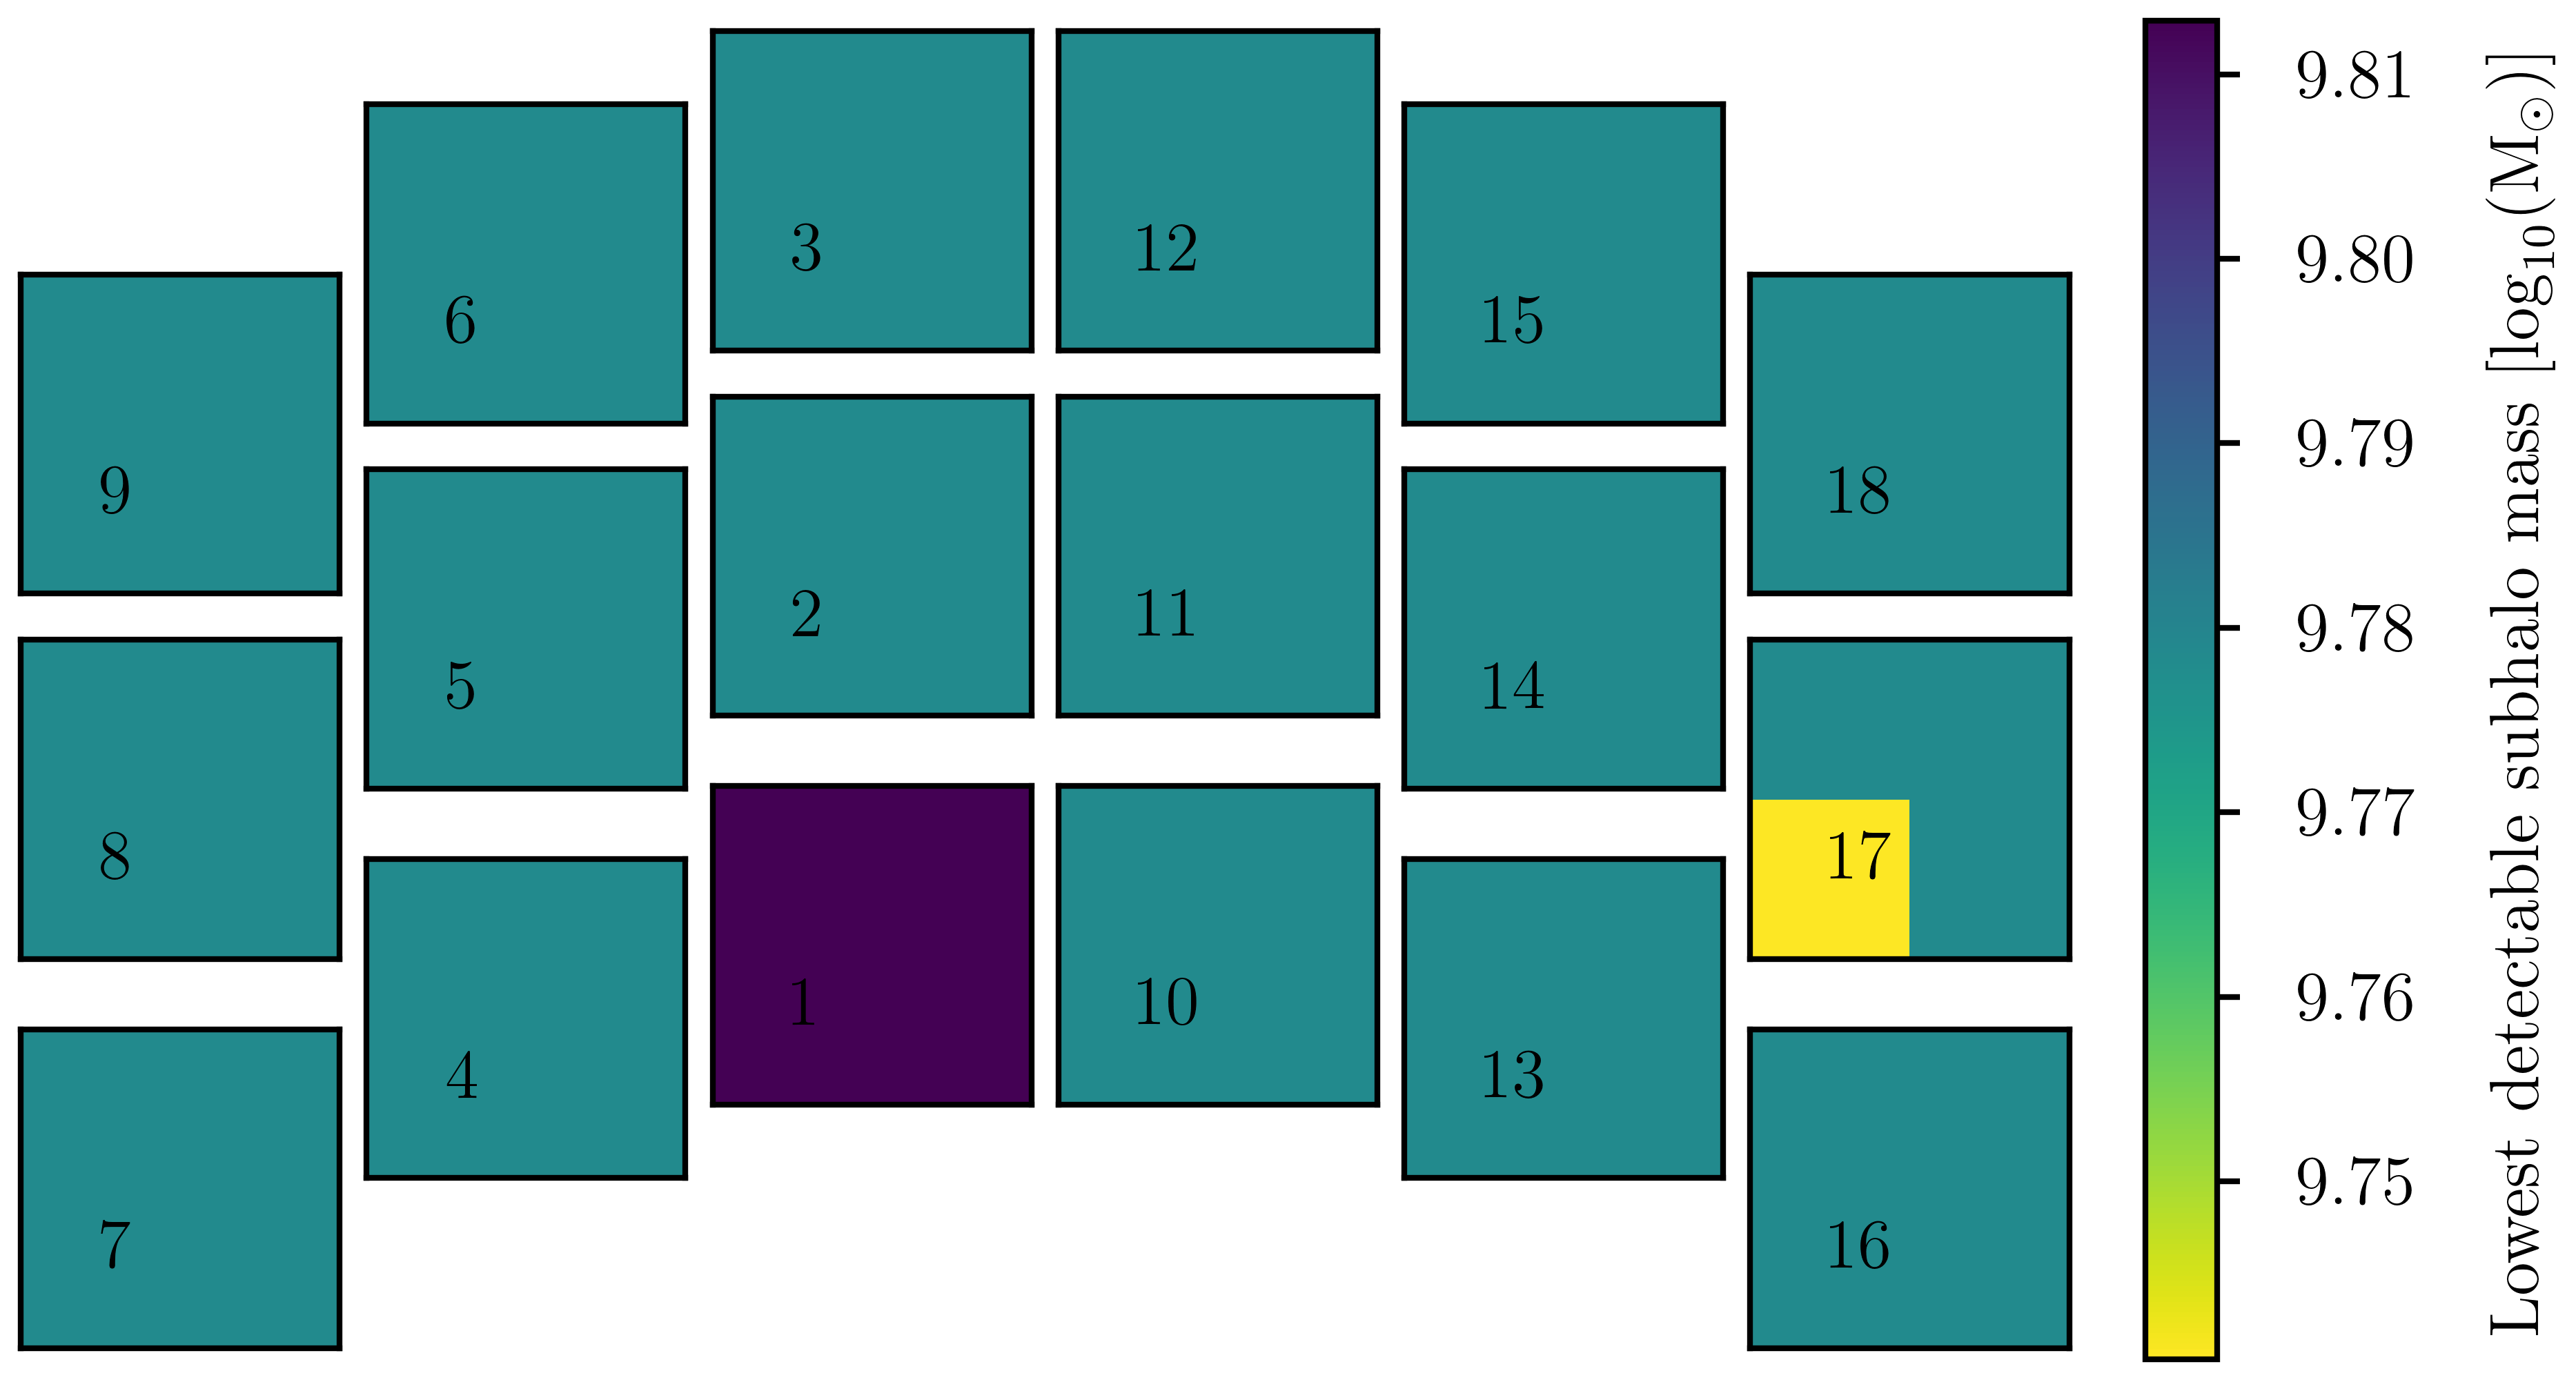

100%|██████████| 72/72 [00:00<00:00, 36882.01it/s]


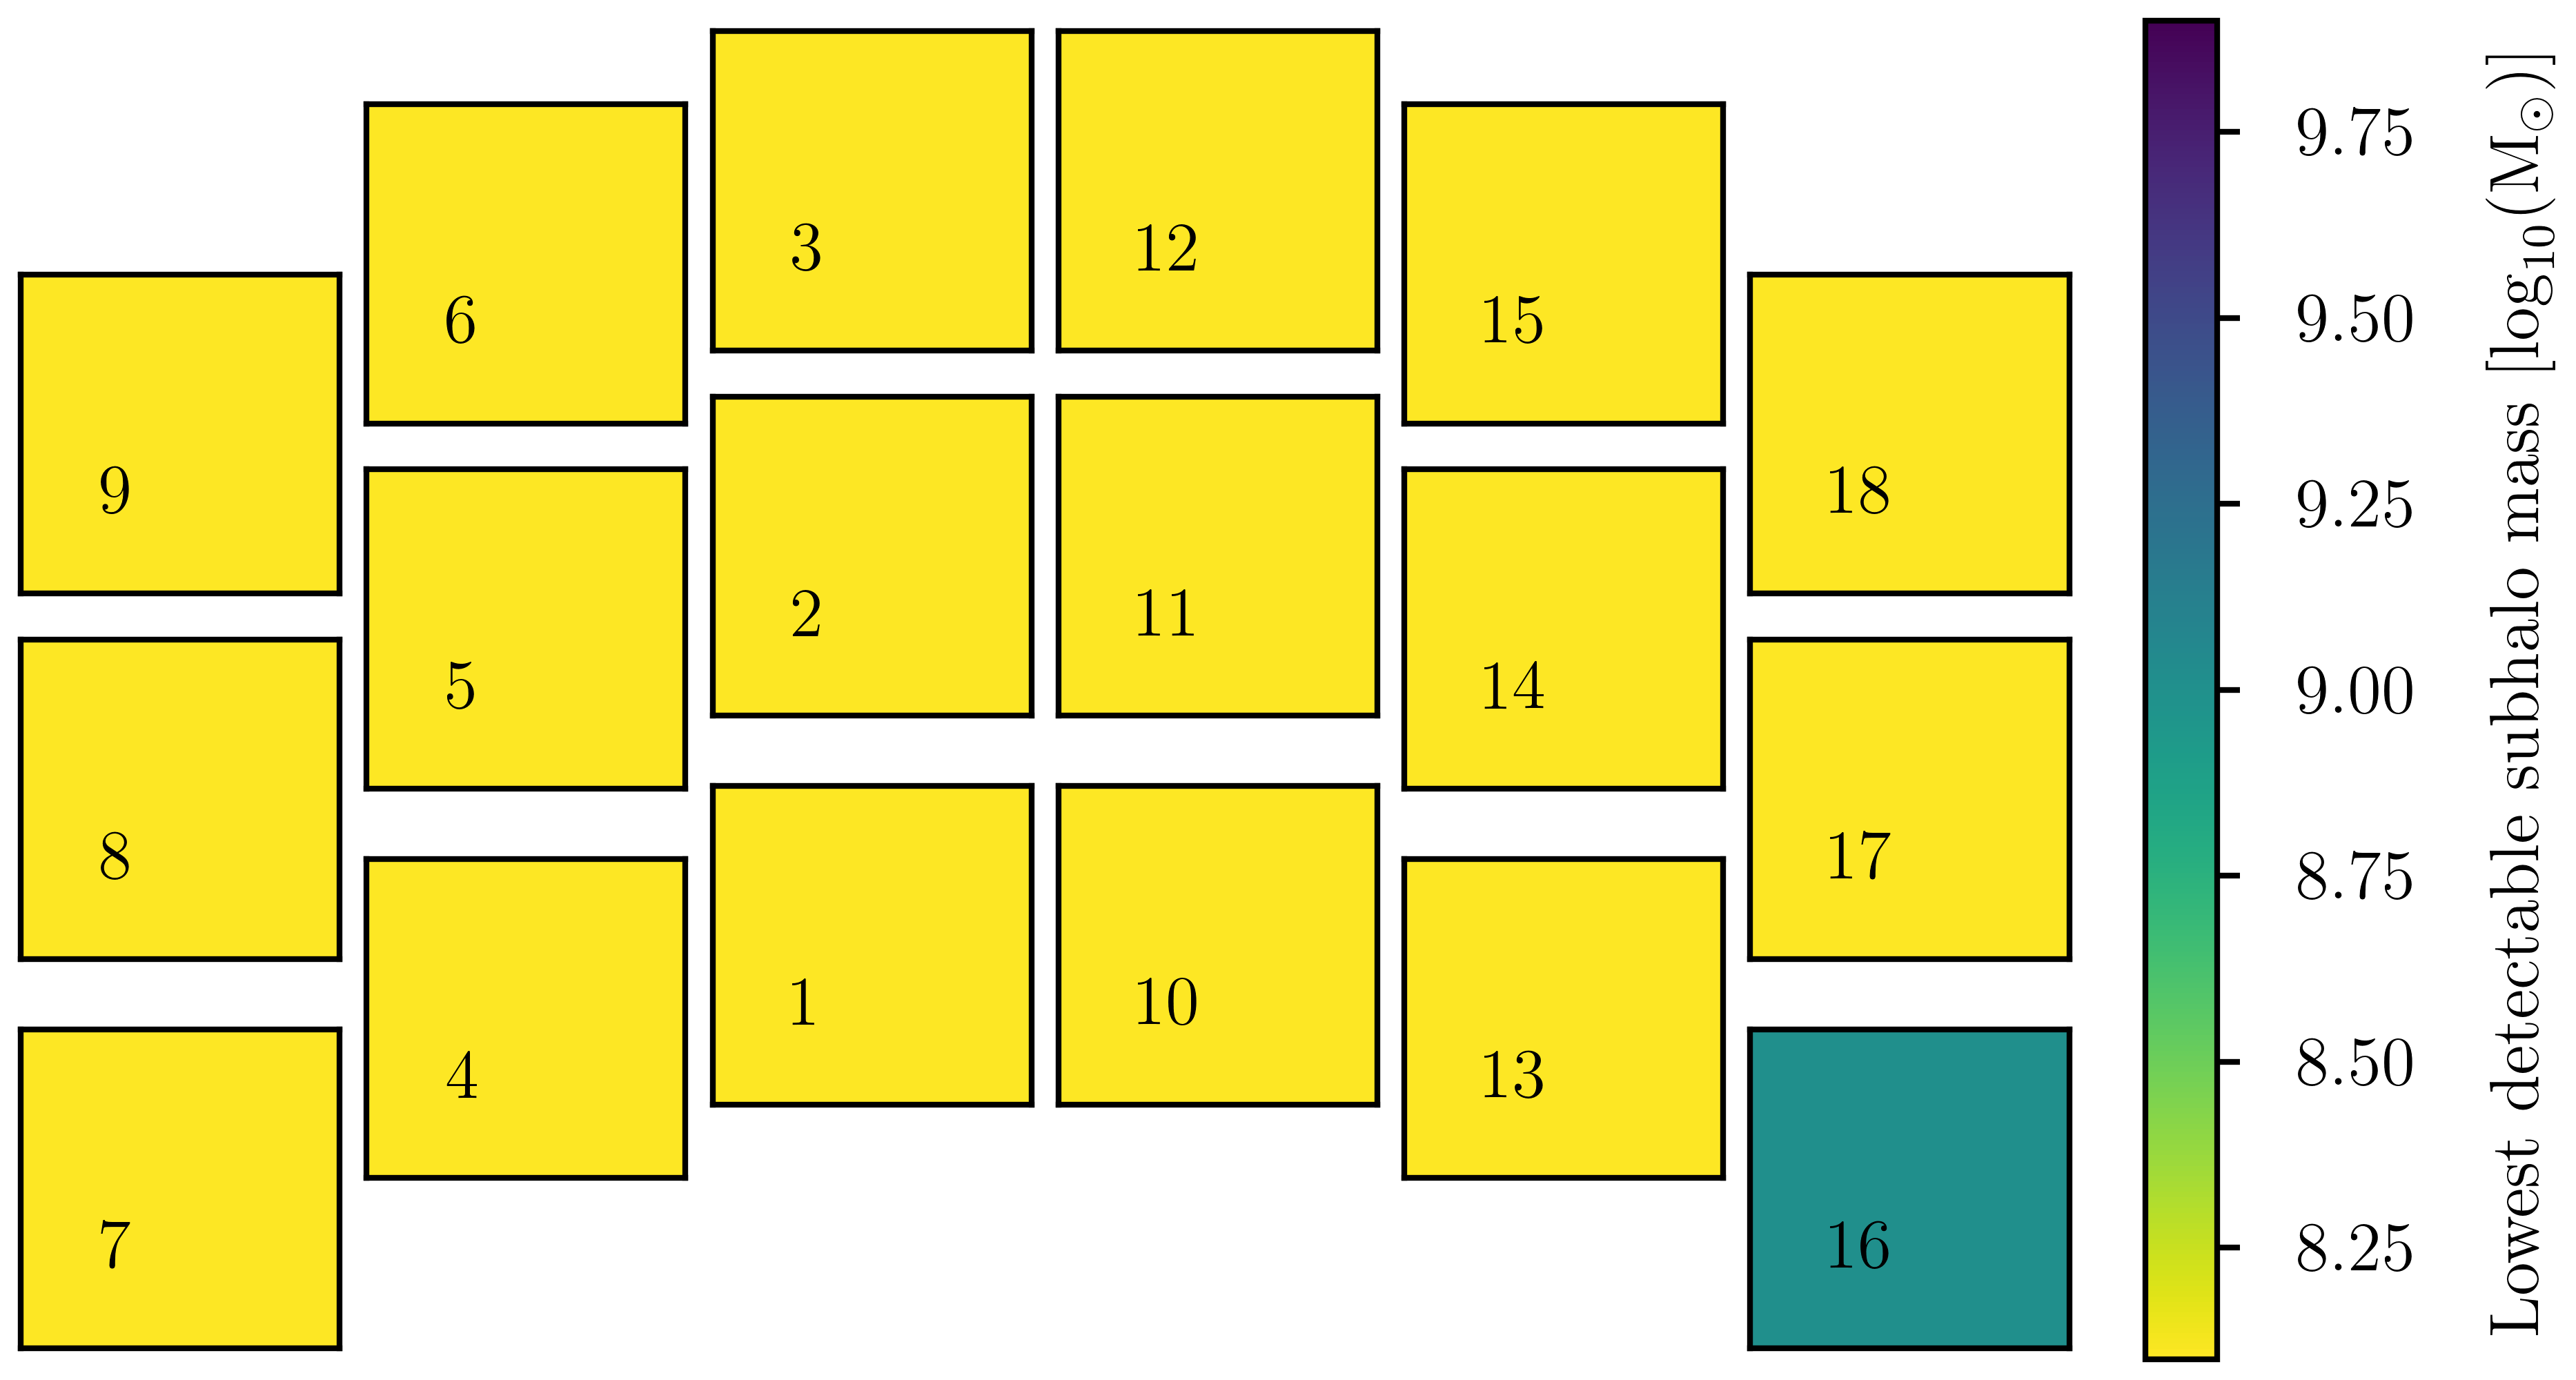

100%|██████████| 72/72 [00:00<00:00, 21637.16it/s]


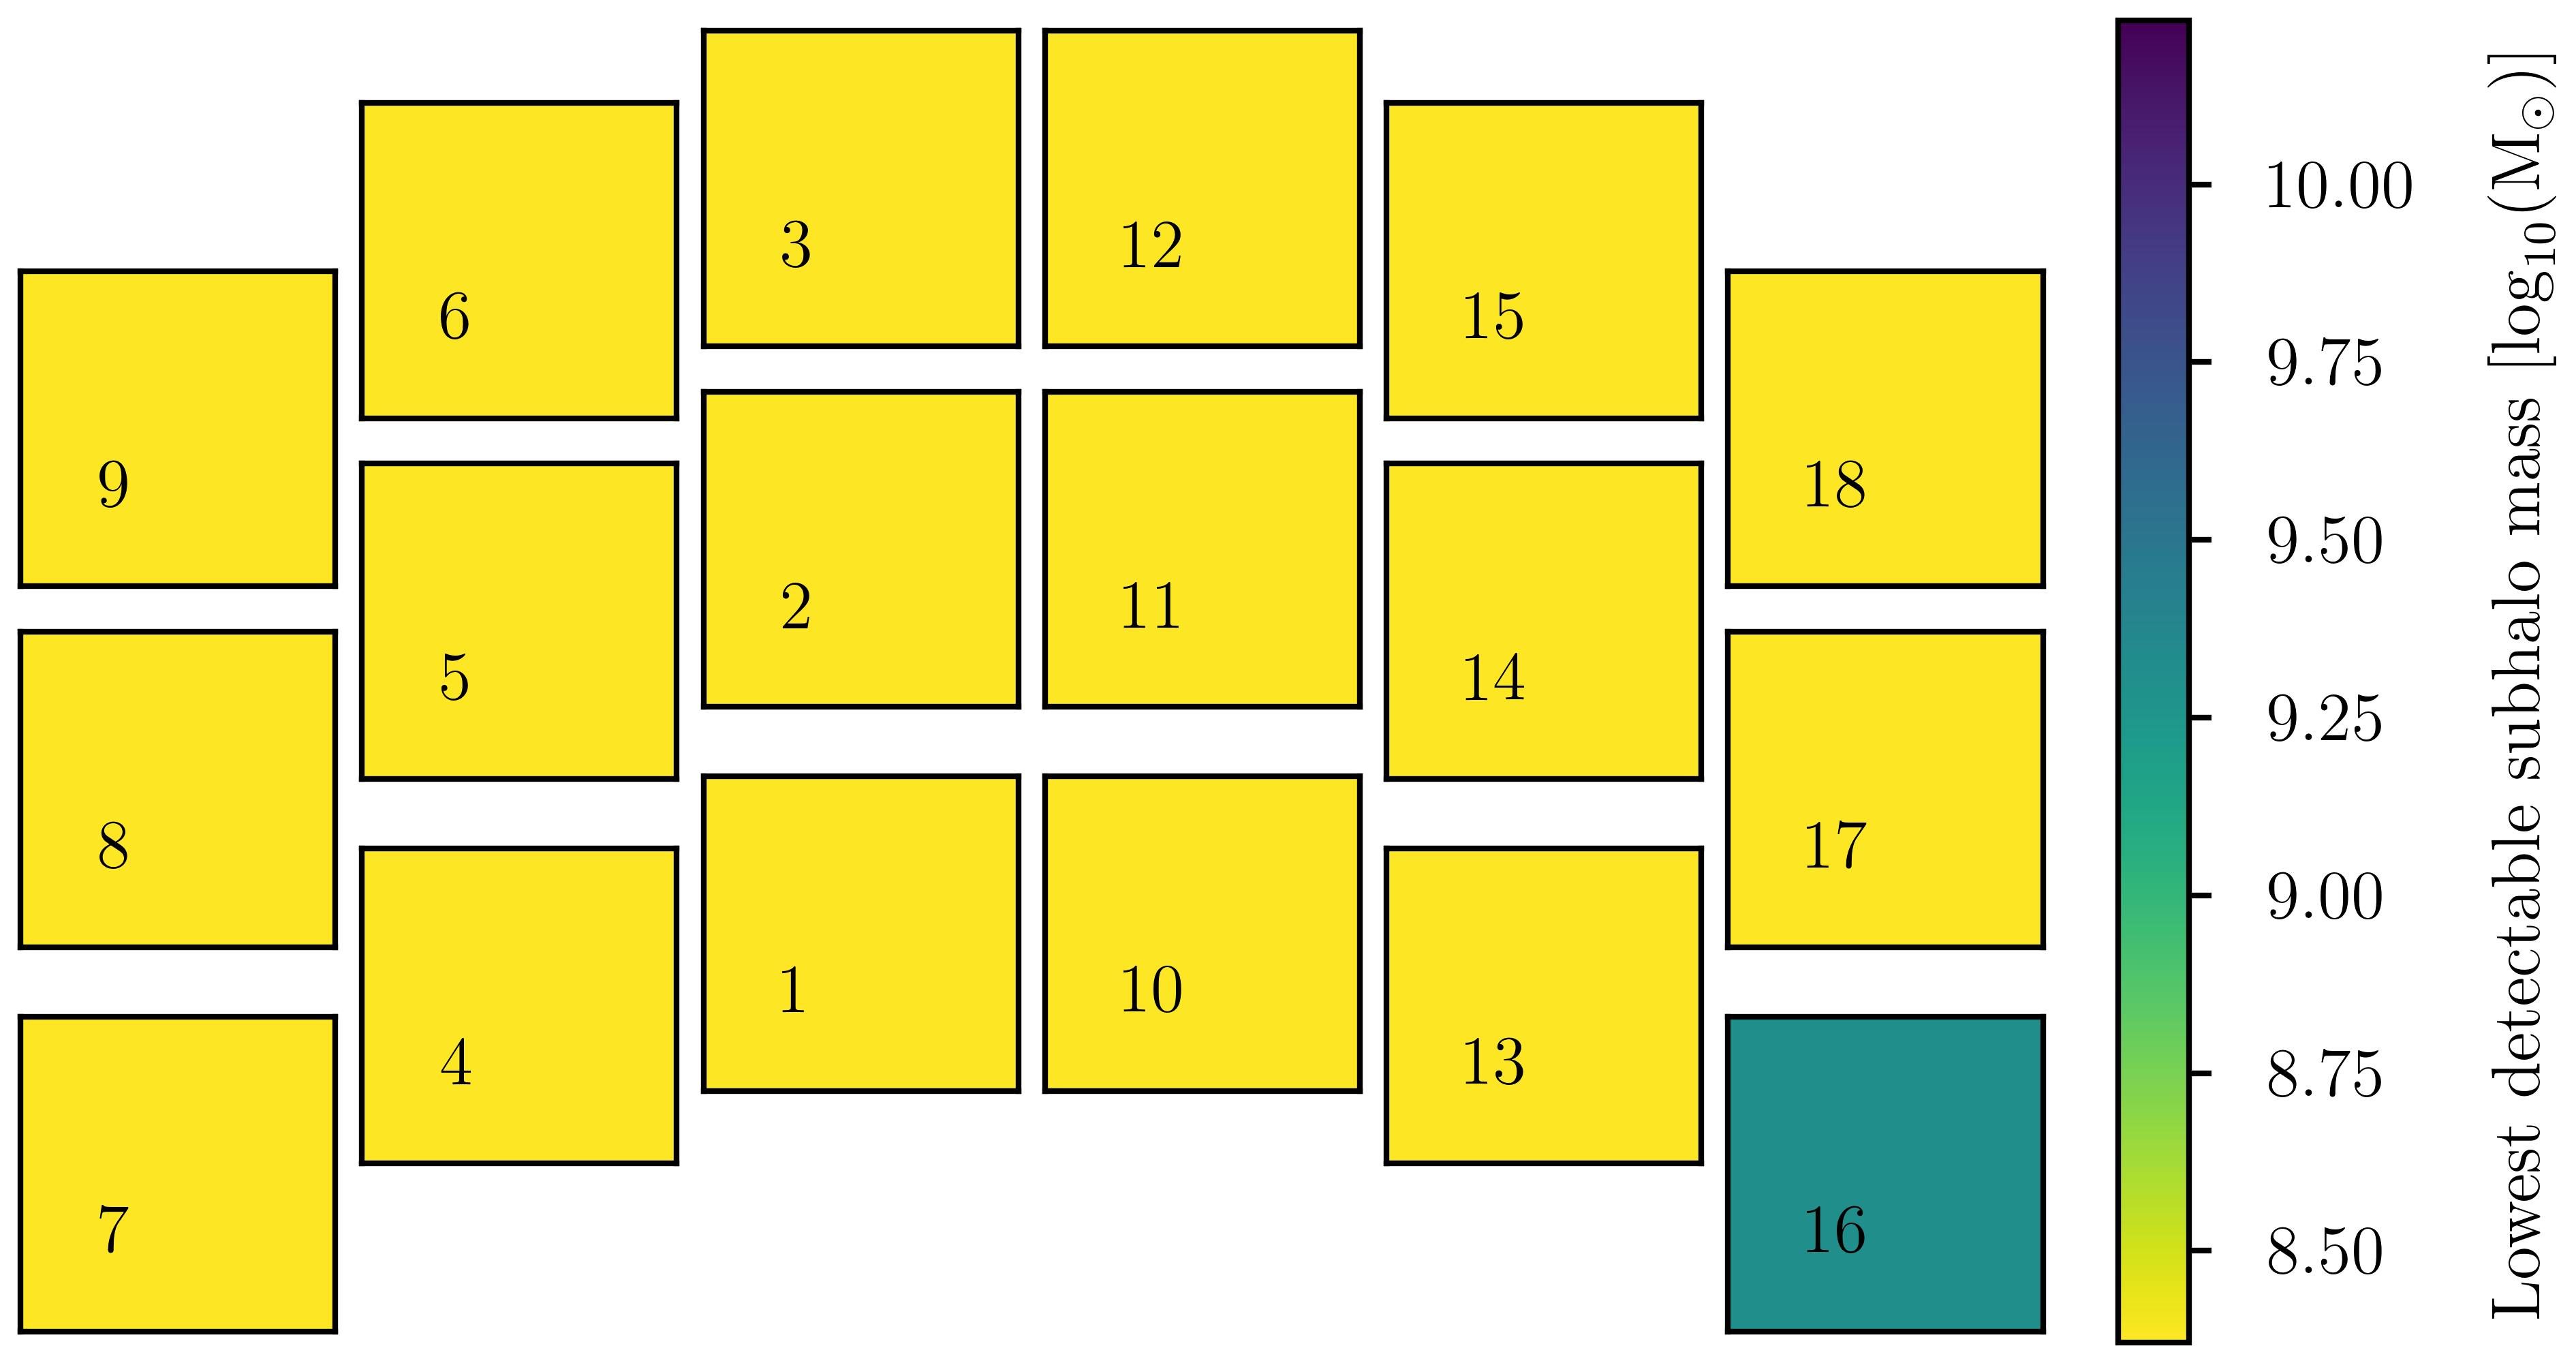

100%|██████████| 72/72 [00:00<00:00, 18294.66it/s]


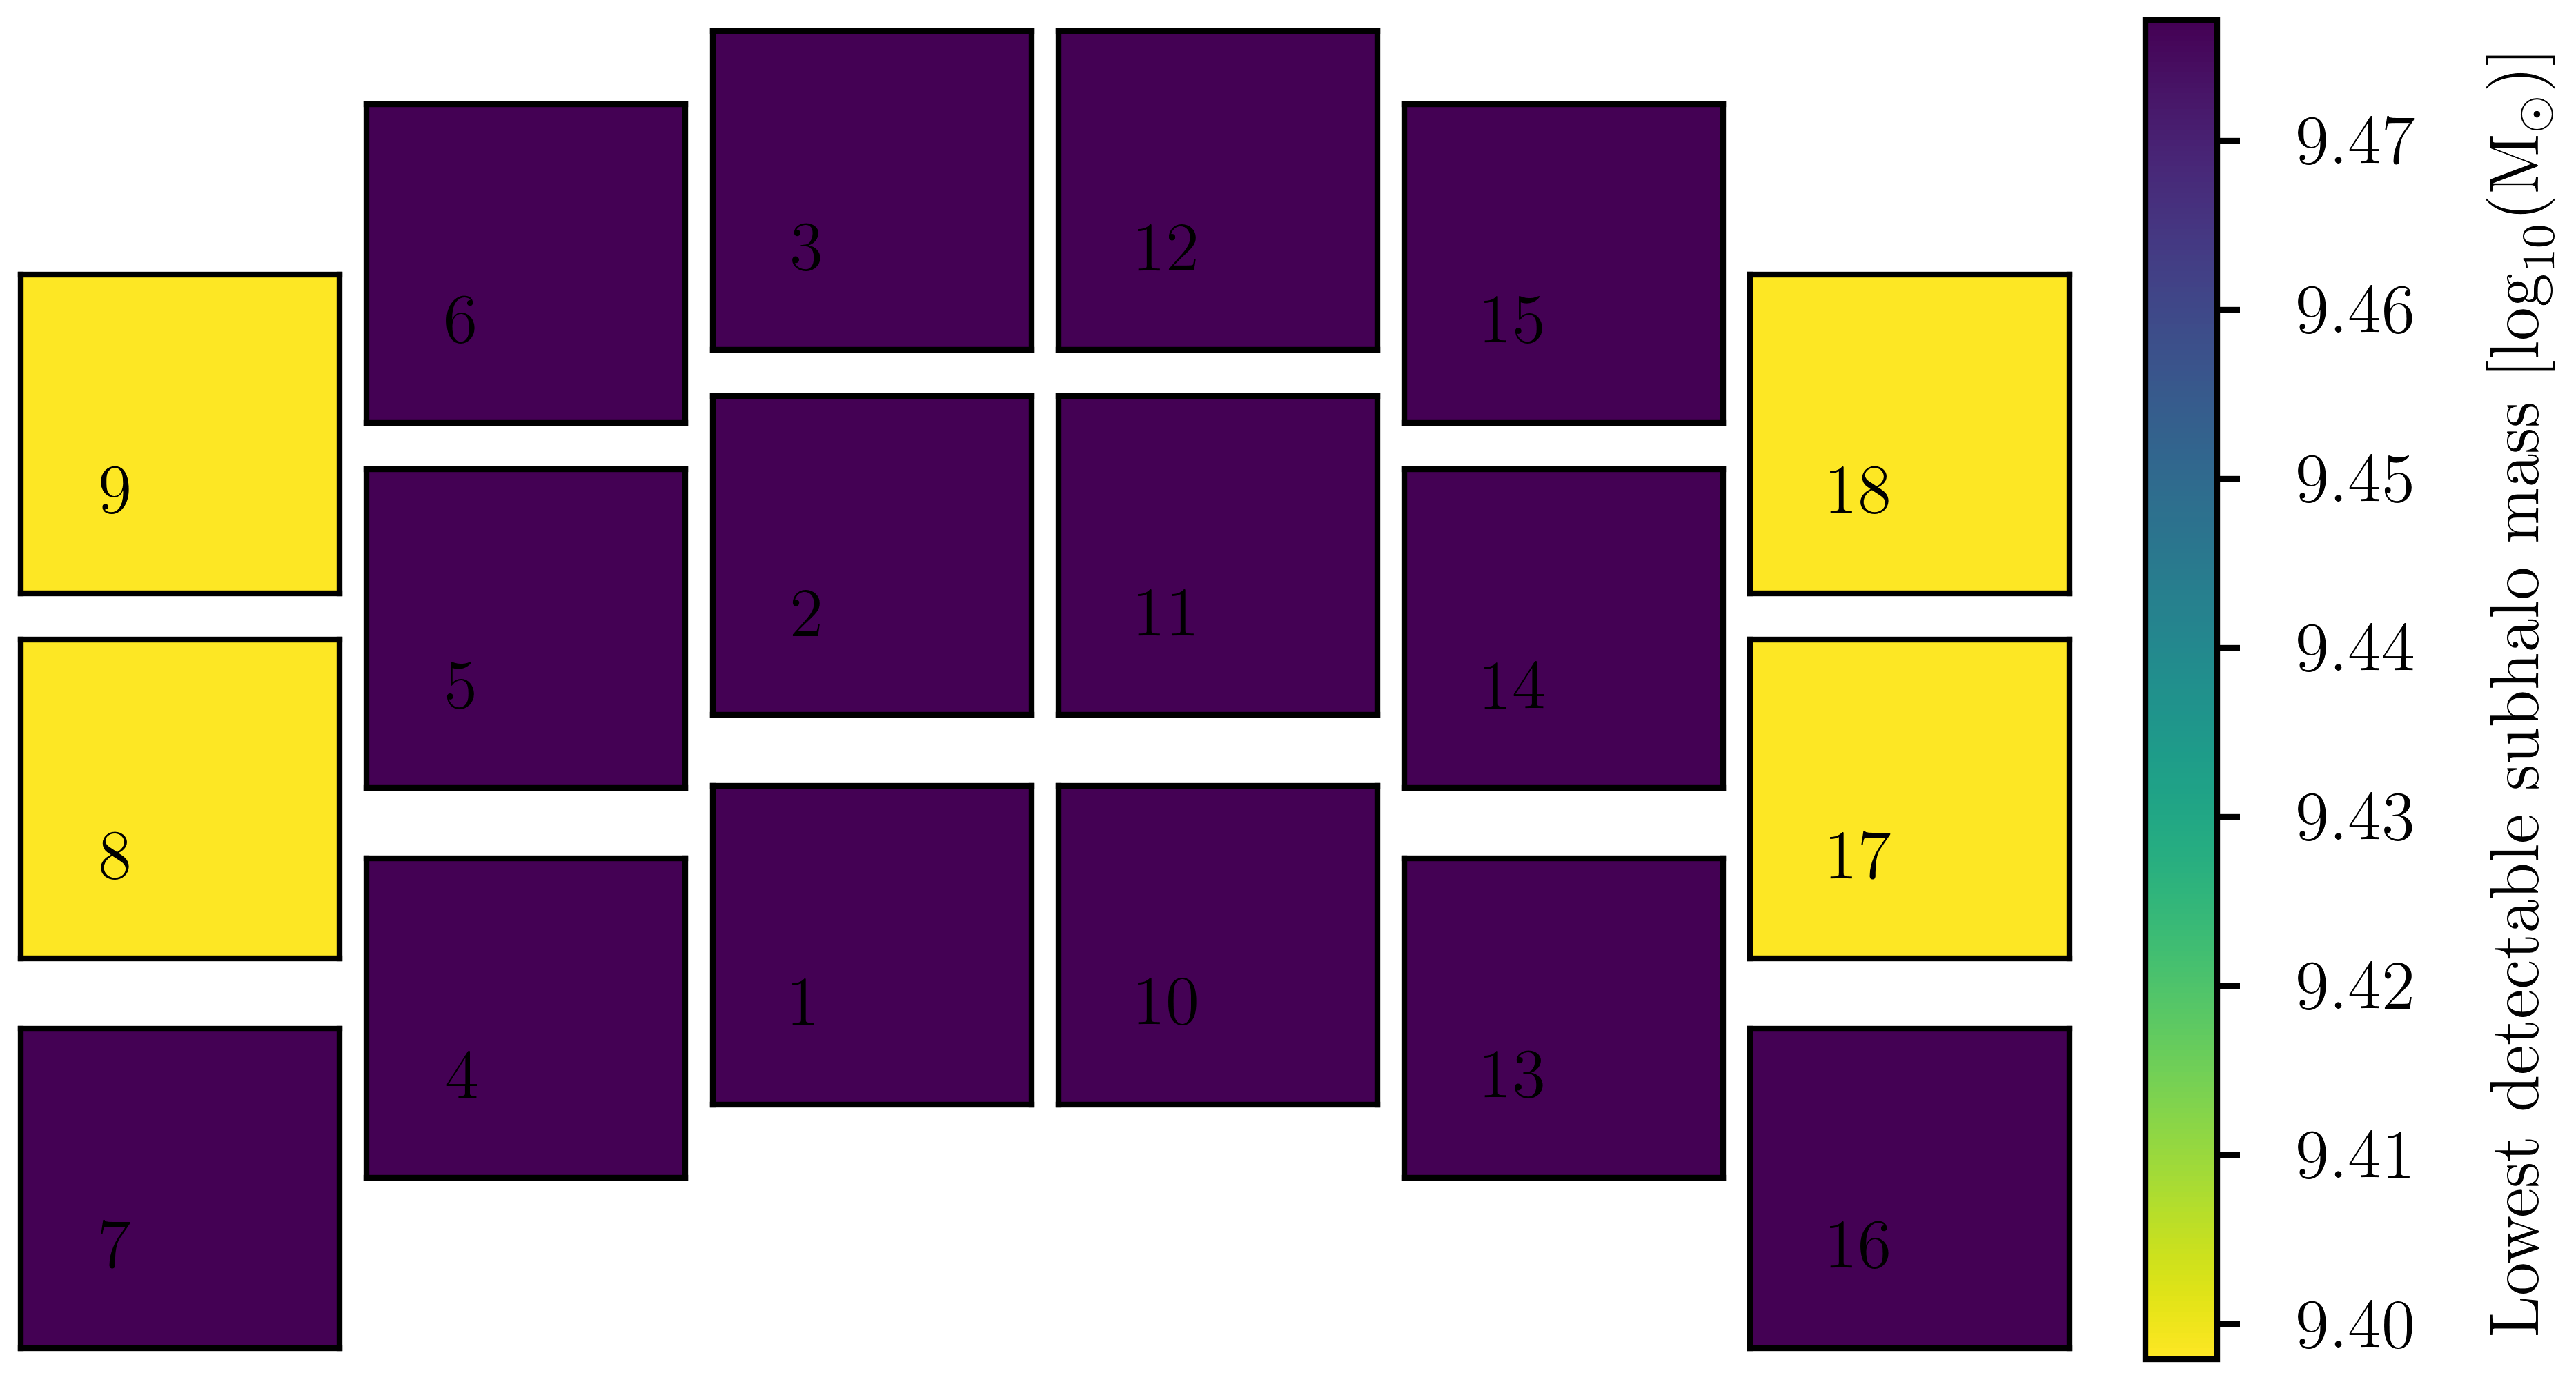

100%|██████████| 72/72 [00:00<00:00, 7612.36it/s]


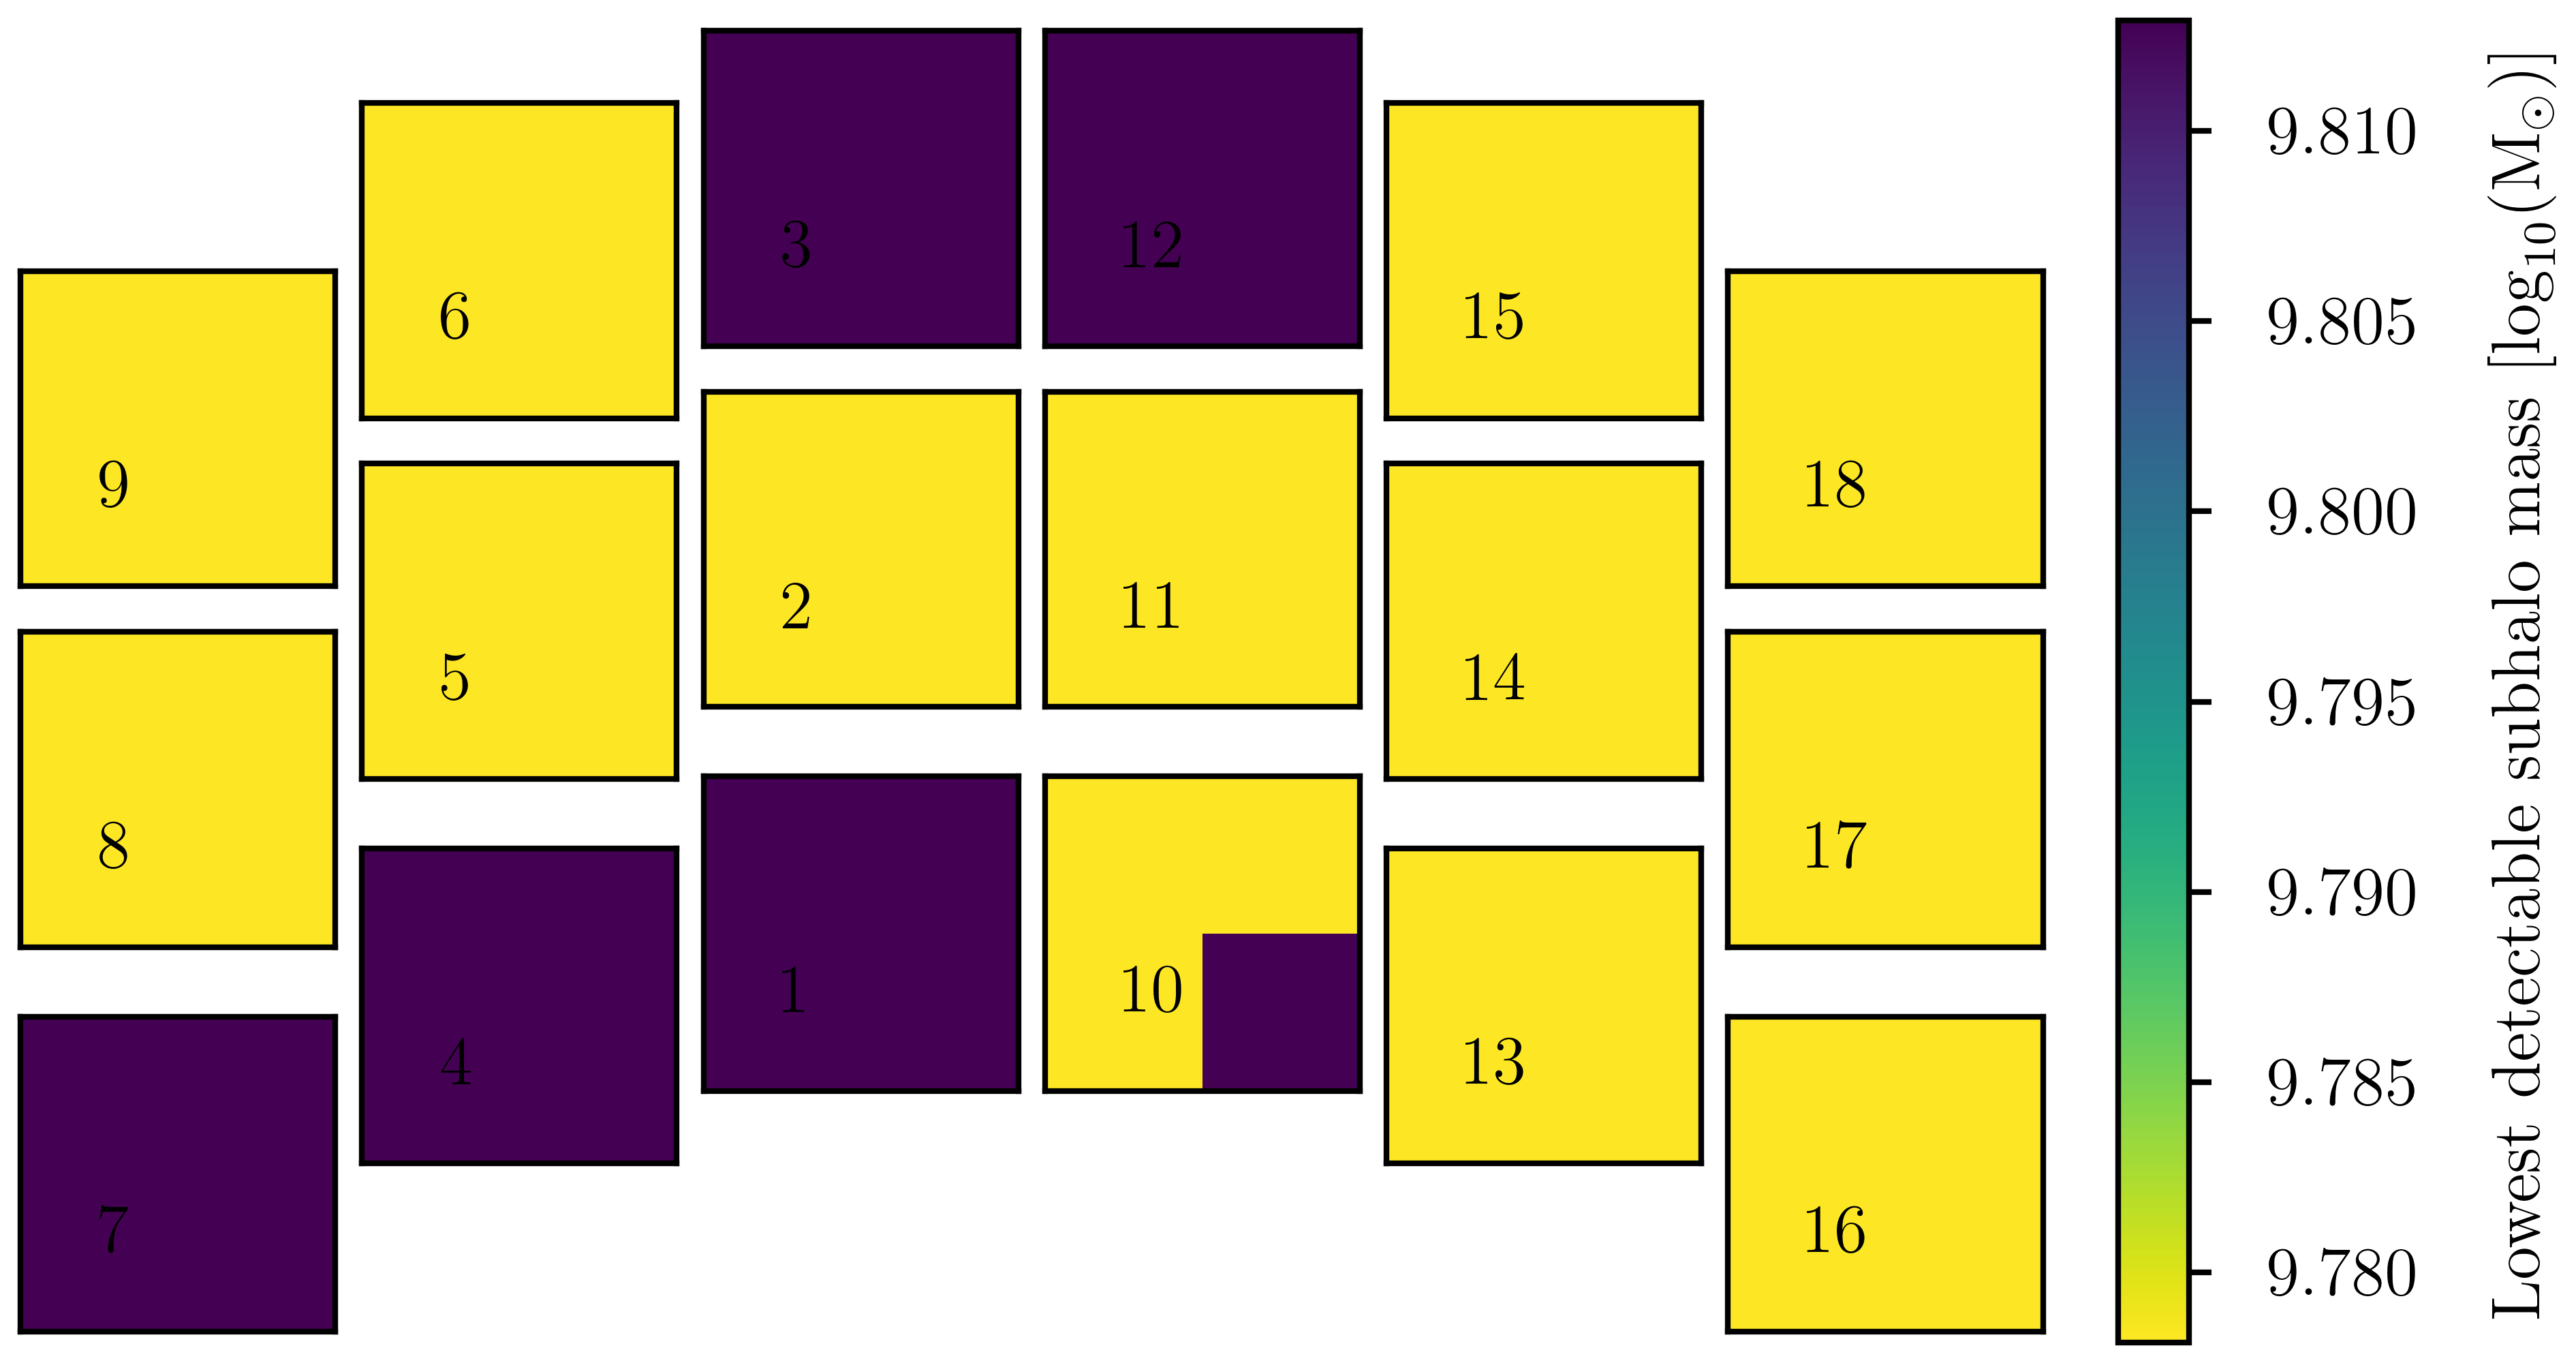

100%|██████████| 72/72 [00:00<00:00, 37715.73it/s]


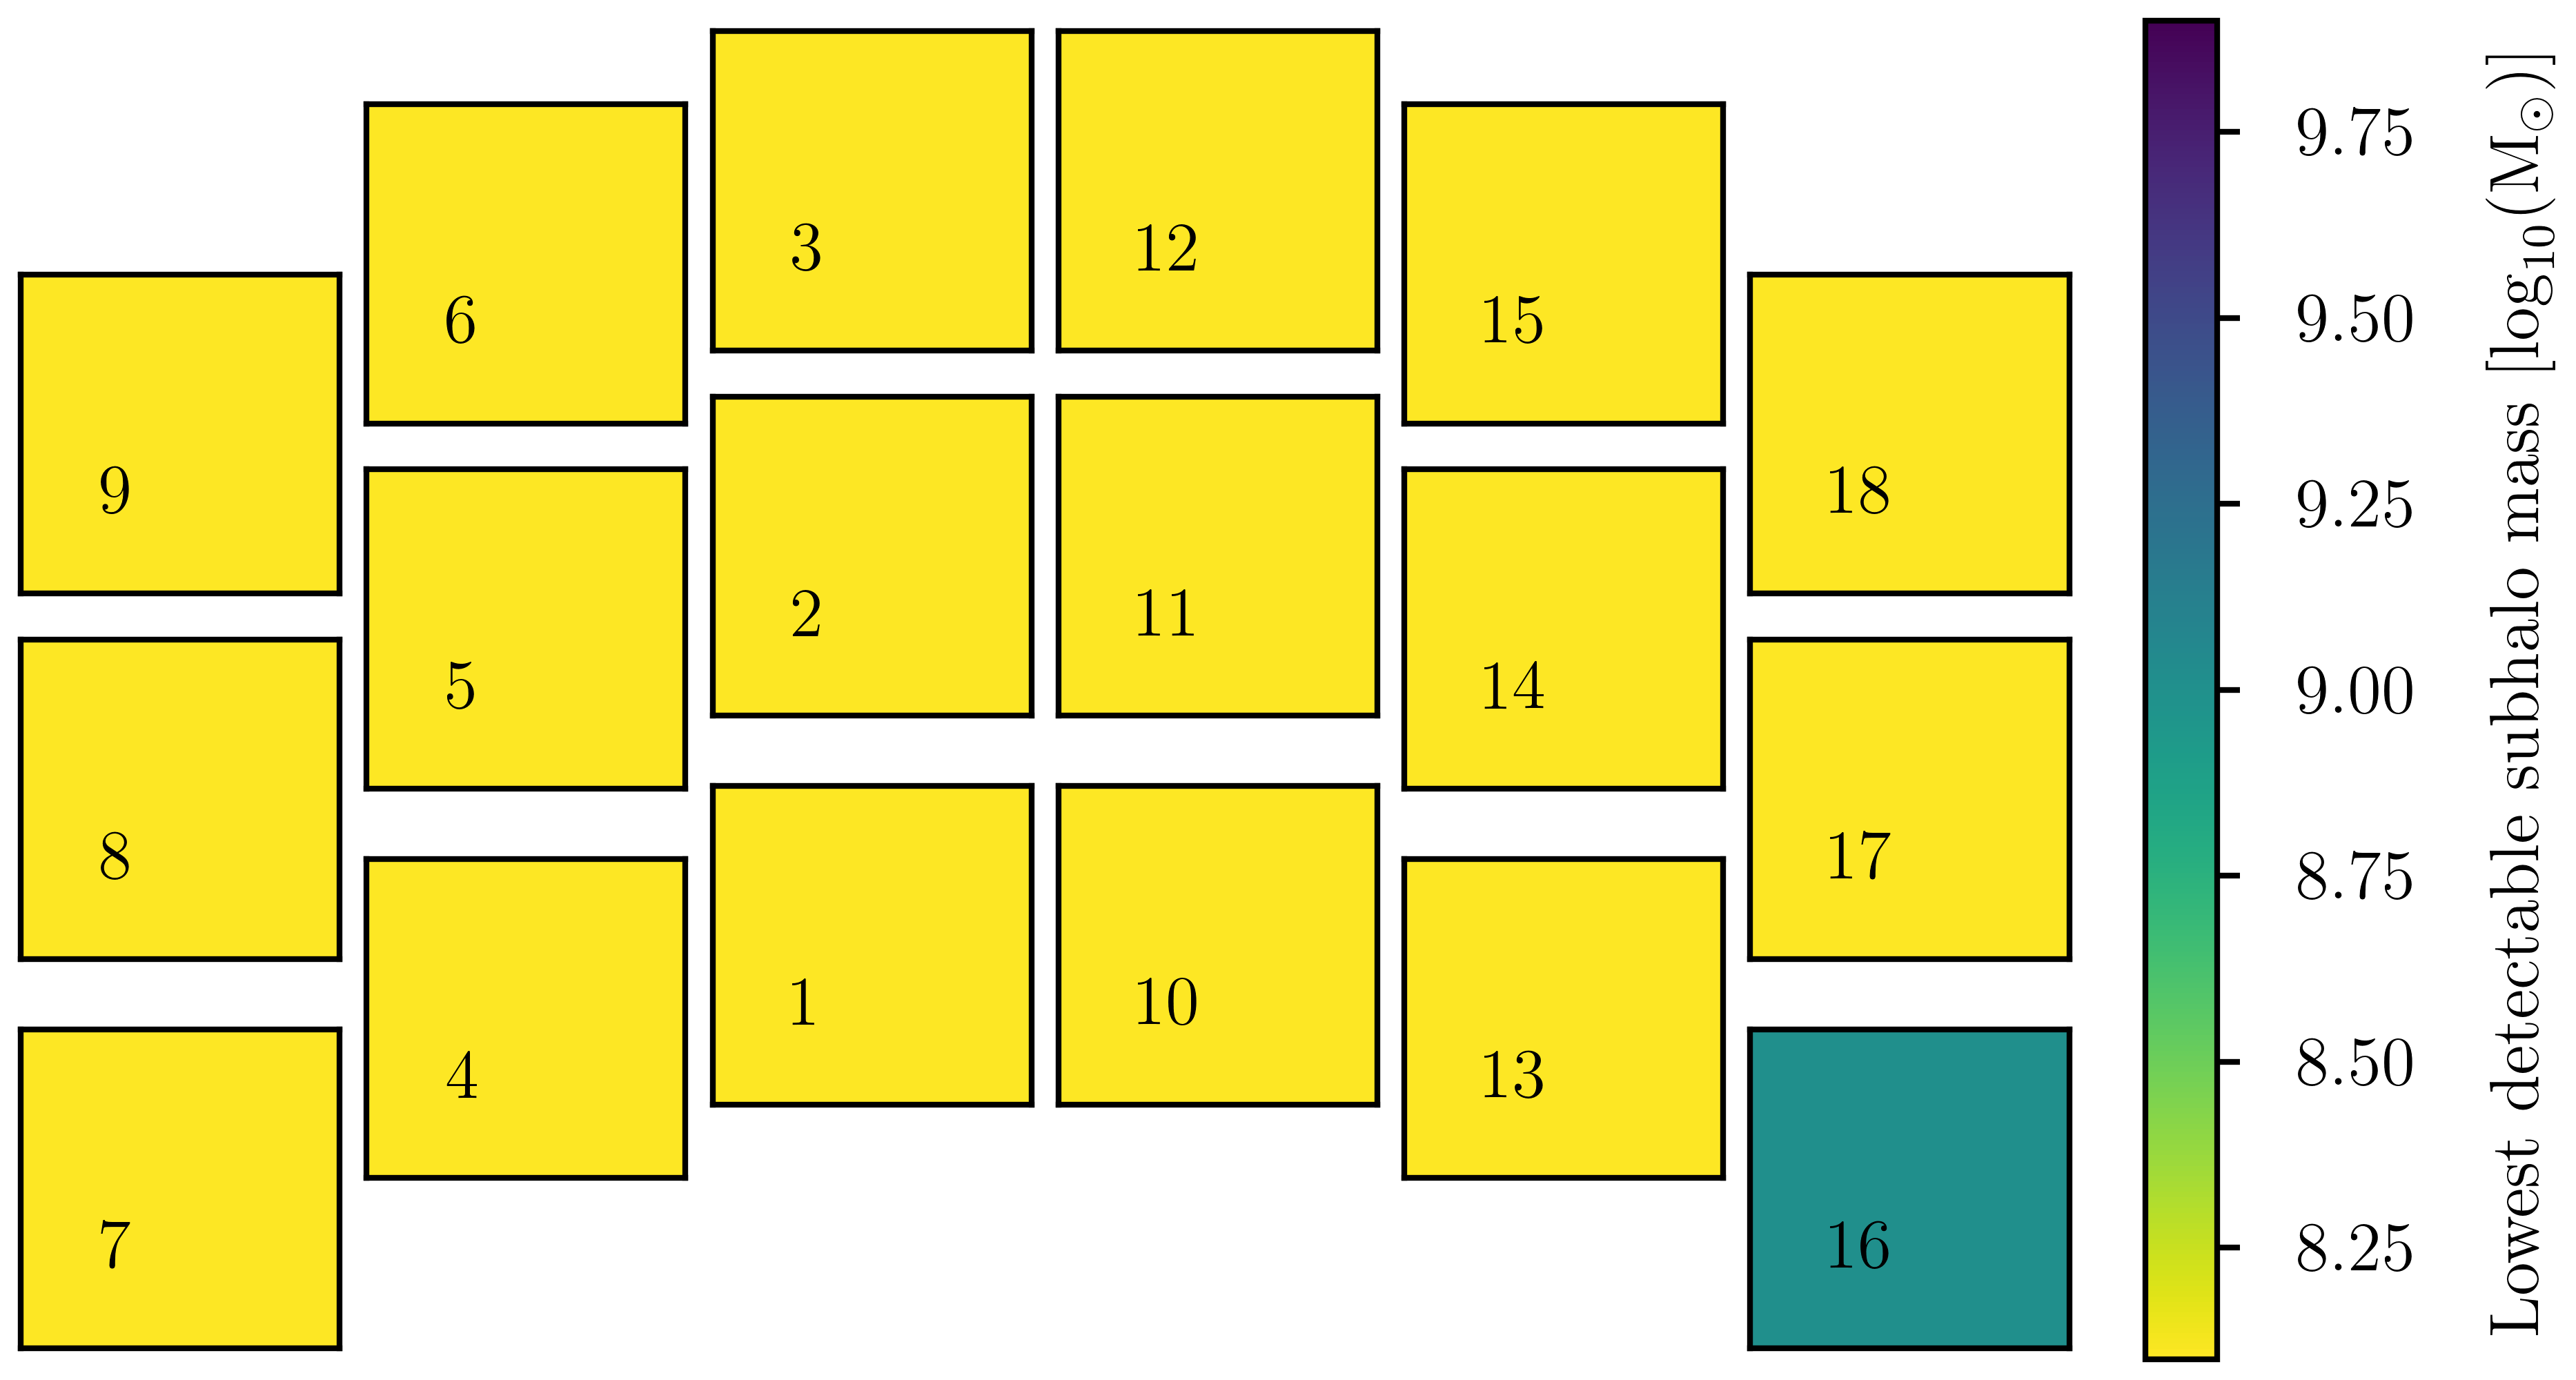

100%|██████████| 72/72 [00:00<00:00, 35654.06it/s]


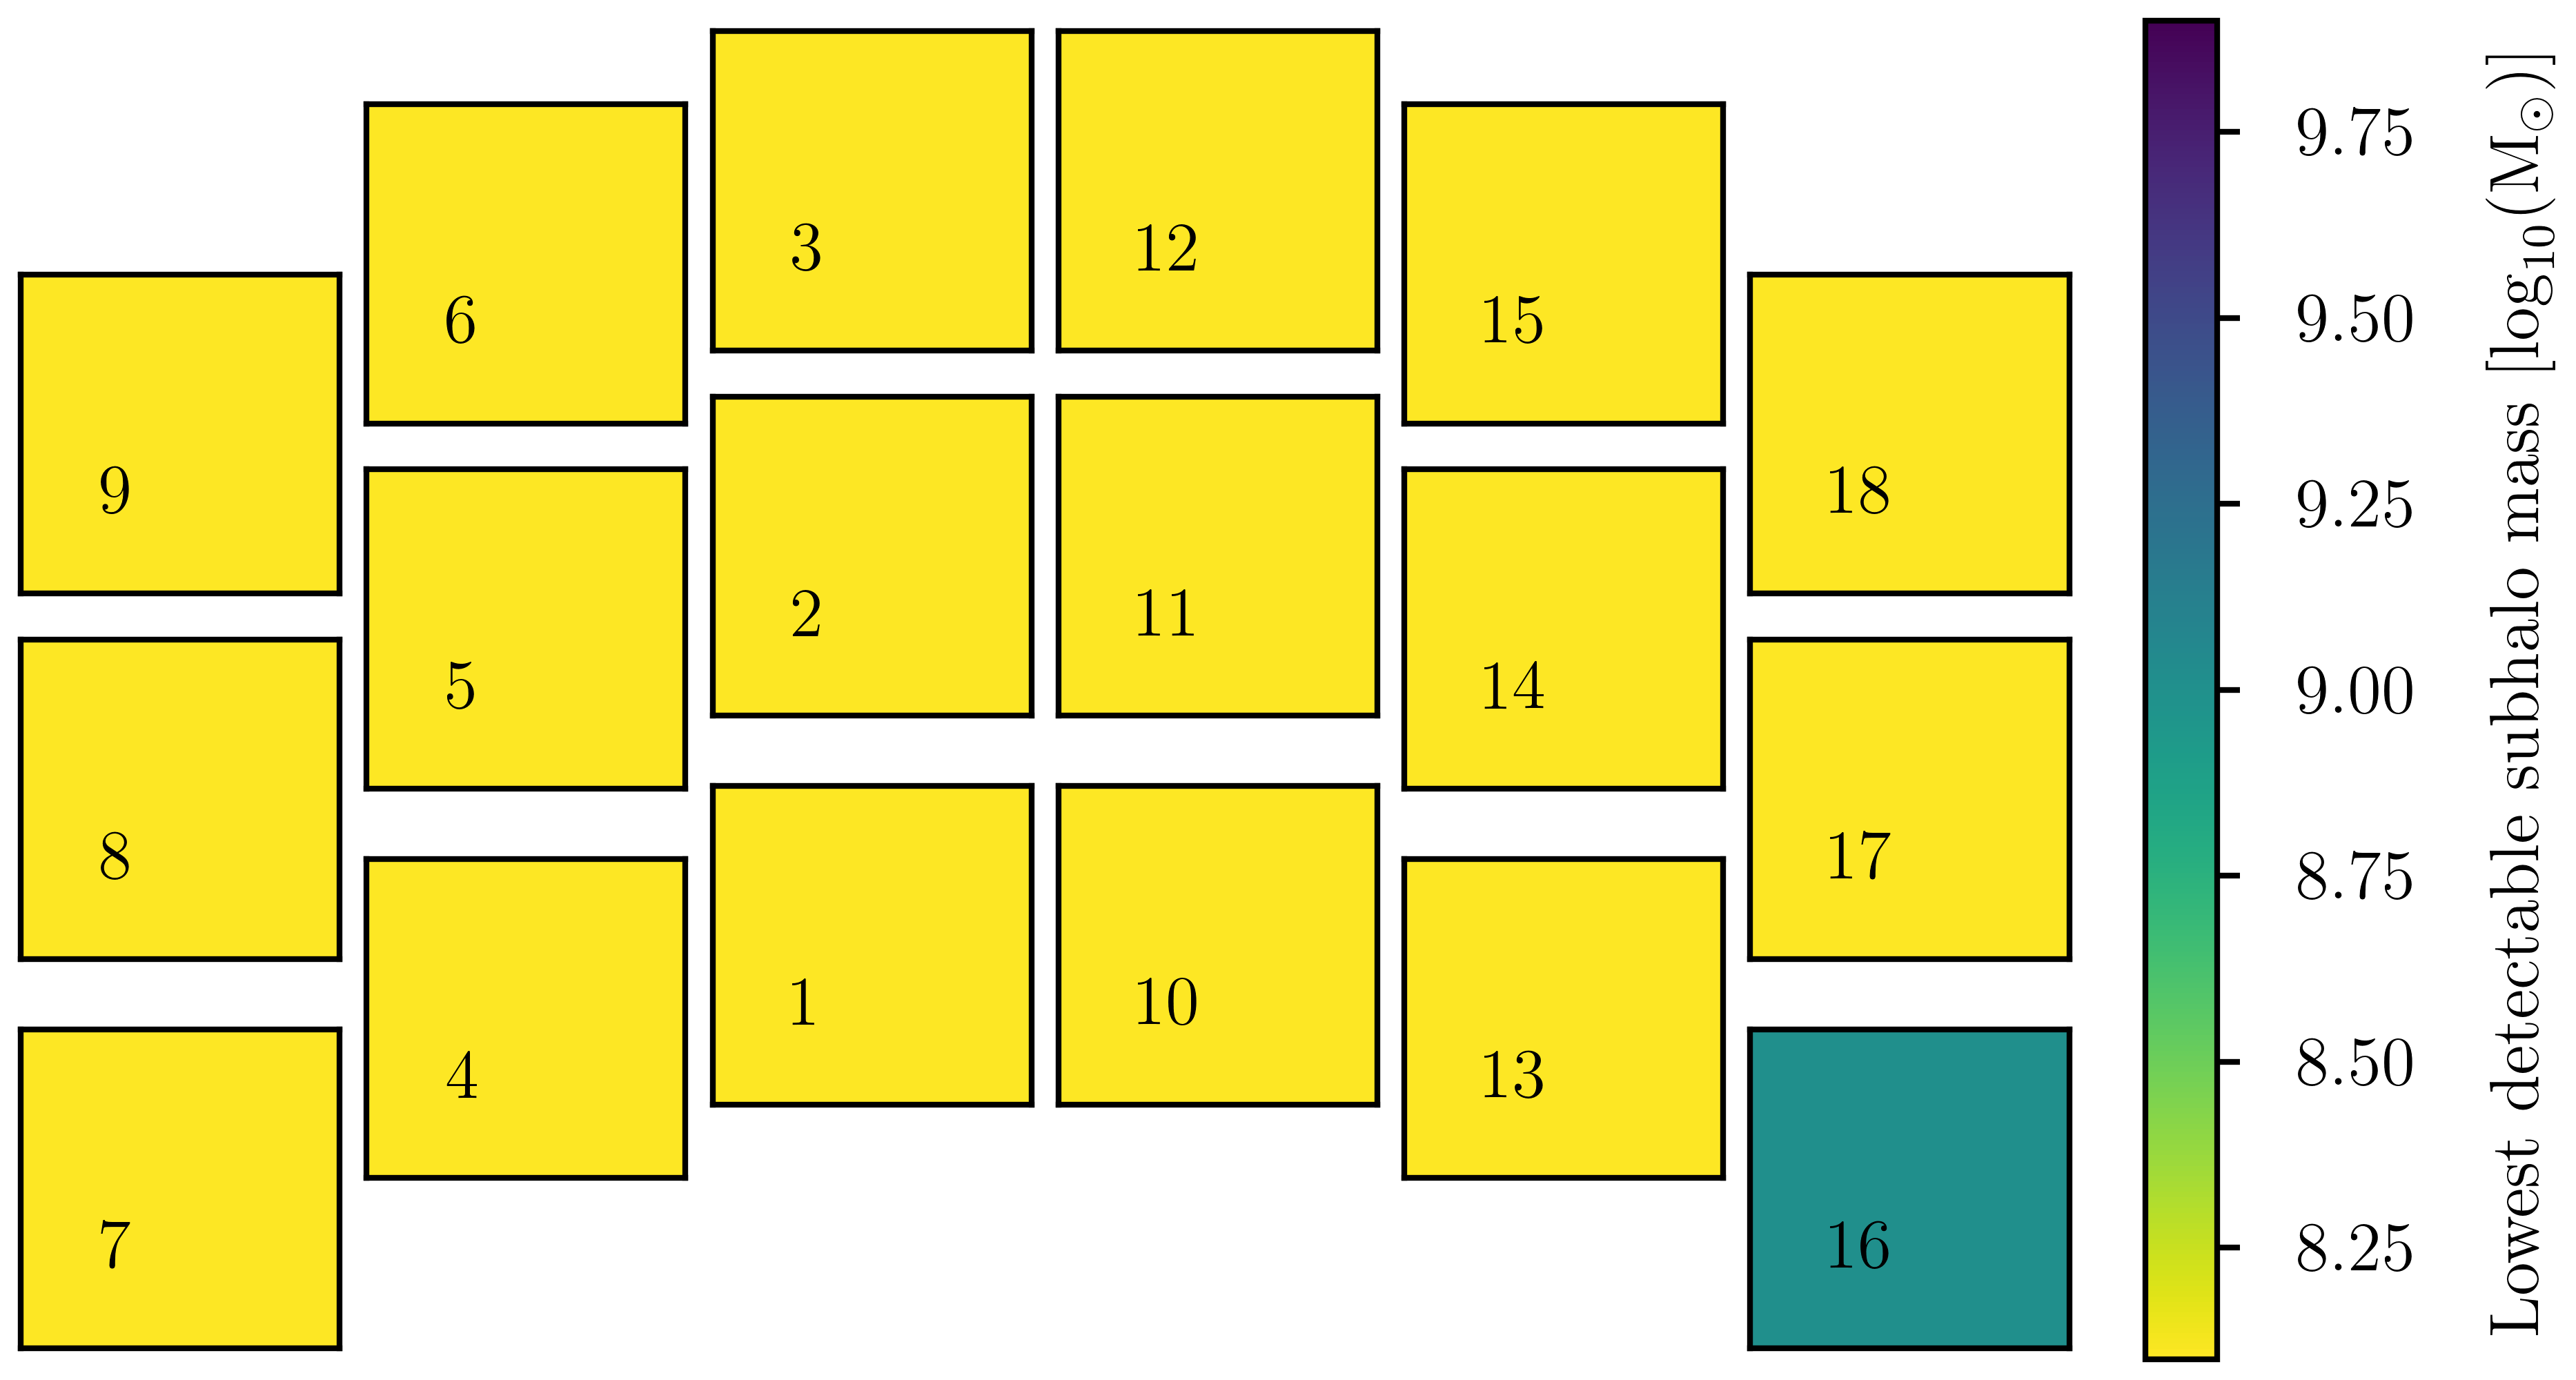

In [70]:
for sample_result in results[:10]:
    array_list = []
    array = np.empty((sides, sides))
    lowest_det_mass_at_position = []

    for sca, sca_position in tqdm(positions):
        position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
        position_results = sample_result[position_key]

        for mass in masses:
            pvals = position_results[str(int(mass))]
            mass = float(mass)
            if np.min(pvals) < pval_threshold:
                # print(f'hit threshold at {mass:.2e}')
                lowest_det_mass_at_position.append(mass)
                break

        # if the last position on the SCA has been reached (top-right corner), populate the array with the masses
        if sca_position == roman_util.divide_up_sca(sides)[-1]:  
            for i in range(sides):
                for j in range(sides):
                    array[i, j] = np.log10(lowest_det_mass_at_position[j * sides + i])

            array_list.append(array)

            # reset the array and median list for the next SCA
            array = np.empty((sides, sides))
            lowest_det_mass_at_position = []

    # vmin, vmax = plot_util.get_min_max(array_list)

    plotting.roman_sca_plot(np.asarray(array_list), 
                            np.arange(1, 19), 
                            residual_plot=False, 
                            show_sca_id=True, 
                            cmap='viridis_r', 
                            savefig=False, 
                            clabel=r'Lowest detectable subhalo mass [$\log_{10}$(M$_\odot$)]',
                            sca_id_pos=(0,0))

    # f, ax = plt.subplots(3, 6, figsize=(12, 6), constrained_layout=True)
    # for i, array in enumerate(array_list):
    #     im = ax[i // 6, i % 6].imshow(array, cmap='viridis', vmin=vmin, vmax=vmax)  # , vmin=np.log10(masses[0]), vmax=np.log10(masses[-1])
    #     ax[i // 6, i % 6].set_title(f'SCA {i + 1}')
    #     ax[i // 6, i % 6].axis('off')
    # cbar = f.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    # cbar.set_label(r'Mean Lowest Detectable Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
    # plt.show()